### Use Python XGBoost and Optuna hyper parameter tuning to build a REGRESSION model and deploy with KNIME Python nodes


<img src="../KNIME_loves_xgboost_optuna.png" width="600">


##### KNIME workflow
https://hub.knime.com/-/spaces/-/latest/~GABT_OgeoWxWJW9P/


##### MEDIUM Blog: Hyperparameter optimization for LightGBM — wrapped in KNIME nodes

https://medium.com/p/ddb7ae1d7e2

###### Optuna

https://optuna.readthedocs.io/en/stable/index.html

###### additional links and texts

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

https://stackoverflow.com/questions/67080149/xgboost-error-when-categorical-type-is-supplied-dmatrix-parameter-enable-cat


https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5


https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

some parameters have been discussed with ChatGPT ....

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json
import pickle
import logging

In [49]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import plotly
import matplotlib
import kaleido

In [3]:
# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "XGBoost_Optuna_Regression"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you do not want to store the files in the working directory
var_path_data = "../"
var_path_model = "../model/"

var_timestamp_day:  20240226
var_timestamp_time:  1814h
var_model_name_full:  XGBoost_Optuna_Regression_20240226_1814h_jupyter


The data used has beed adapted from:

**Census Income Data Set**

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

Extract and prepare the Census Income Files for usage in KNIME

https://archive.ics.uci.edu/ml/datasets/census+income

In [4]:
data      = pq.read_table(var_path_data + "dataset_regression_80.parquet").to_pandas()
data_test = pq.read_table(var_path_data + "dataset_regression_20.parquet").to_pandas()

In [5]:
data = data.reset_index(drop=True)

In [6]:
data_test = data_test.reset_index(drop=True)

In [7]:
excluded_features = ['row_id']
label = ['Target']
# features = [feat for feat in data.columns if feat not in excluded_features and not feat==label]
features = [feat for feat in data.columns if feat not in excluded_features and feat not in label]

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
rest columns: {rest_cols}''')

# THX David Gutmann 

data shape:          (1183, 80)
data[features] shape: (1183, 79)
categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Tot

In [8]:
print(data.dtypes)

MSSubClass         int32
MSZoning          object
LotFrontage      float64
LotArea            int32
Street            object
                  ...   
MoSold             int32
YrSold             int32
SaleType          object
SaleCondition     object
Target             int32
Length: 80, dtype: object


In [9]:
data[cat_cols] = data[cat_cols].astype('category')

In [10]:
data[label] = data[label].astype('int32')

In [11]:
print(data.dtypes)

MSSubClass          int32
MSZoning         category
LotFrontage       float64
LotArea             int32
Street           category
                   ...   
MoSold              int32
YrSold              int32
SaleType         category
SaleCondition    category
Target              int32
Length: 80, dtype: object


In [12]:
# split training data into X and y
X = data[features]
y = data[label]

In [13]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,NA,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,12,2008,WD,Normal


In [14]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [15]:
D_train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
D_test = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [16]:
# y_train = np.ravel(y_train)
# y_test = np.ravel(y_test)

In [61]:
# number of iterations
var_n_boost_round = 200

def objective(trial):
    param = {
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        # 'scale_pos_weight' is not typically used for regression, so it can be removed.
        'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'objective': 'reg:squarederror',  # Changed to regression objective
        'eval_metric': 'rmse',  # Changed to regression metric
        'min_split_loss': trial.suggest_float('min_split_loss', 1e-8, 1.0),
        'max_bin': trial.suggest_int('max_bin', 64, 512),
        'seed': 42,
        'n_jobs': -1
    }

    # Train model with the given hyperparameters
    model = xgb.train(param, D_train, num_boost_round=var_n_boost_round, evals=[(D_test, 'val')], early_stopping_rounds=25, verbose_eval=50)
    
    # Predict and calculate RMSE score on validation set
    y_val_pred = model.predict(D_test)
    rmse = root_mean_squared_error(y_test, y_val_pred)

    return rmse


In [62]:
var_n_trials = var_n_boost_round

# Create Optuna study and optimize the objective function
# Change the direction to 'minimize' since we want to minimize the RMSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=var_n_trials)

# Get the best hyperparameters and best RMSE score
best_params = study.best_params
best_score = study.best_value  # This will be the lowest RMSE achieved



[I 2024-02-26 18:45:36,752] A new study created in memory with name: no-name-a8d8906f-f656-4532-938c-cd95f25bfdf1


[0]	val-rmse:74767.07412
[50]	val-rmse:74731.57086
[100]	val-rmse:74696.05535
[150]	val-rmse:74660.26334
[199]	val-rmse:74625.64829


[I 2024-02-26 18:45:37,093] Trial 0 finished with value: 74625.64773347598 and parameters: {'eta': 0.2980042197143976, 'max_depth': 12, 'subsample': 0.358626619445987, 'colsample_bytree': 0.9743298962492325, 'gamma': 0.878209487472033, 'alpha': 0.9889505451701203, 'lambda': 0.6536562153196213, 'min_child_weight': 7, 'max_delta_step': 8, 'tree_method': 'auto', 'learning_rate': 0.1360539294046239, 'min_split_loss': 0.4756349822993132, 'max_bin': 212}. Best is trial 0 with value: 74625.64773347598.


[0]	val-rmse:74767.33738
[50]	val-rmse:74744.83826
[100]	val-rmse:74722.13684
[150]	val-rmse:74699.77120
[199]	val-rmse:74677.75520


[I 2024-02-26 18:45:37,463] Trial 1 finished with value: 74677.7543852994 and parameters: {'eta': 0.10004573541715123, 'max_depth': 9, 'subsample': 0.91413500887606, 'colsample_bytree': 0.126739643167345, 'gamma': 0.2836592675806993, 'alpha': 0.0006406924227209125, 'lambda': 0.8557297631367903, 'min_child_weight': 5, 'max_delta_step': 7, 'tree_method': 'hist', 'learning_rate': 0.10563620501192747, 'min_split_loss': 0.6641303281253724, 'max_bin': 96}. Best is trial 0 with value: 74625.64773347598.


[0]	val-rmse:74767.30405
[50]	val-rmse:74743.90131
[100]	val-rmse:74720.51638
[150]	val-rmse:74697.15317
[199]	val-rmse:74674.37259


[I 2024-02-26 18:45:37,937] Trial 2 finished with value: 74674.37213742879 and parameters: {'eta': 0.026689838747231492, 'max_depth': 6, 'subsample': 0.6241796233314593, 'colsample_bytree': 0.7981611723112052, 'gamma': 0.1135749014258733, 'alpha': 0.36663230469845826, 'lambda': 0.23414024800856764, 'min_child_weight': 3, 'max_delta_step': 7, 'tree_method': 'approx', 'learning_rate': 0.09980073966044244, 'min_split_loss': 0.945943296411609, 'max_bin': 499}. Best is trial 0 with value: 74625.64773347598.


[0]	val-rmse:72842.40667
[50]	val-rmse:28752.92125
[100]	val-rmse:21893.42560
[150]	val-rmse:21219.30053
[199]	val-rmse:20698.77733


[I 2024-02-26 18:45:38,577] Trial 3 finished with value: 20698.77721265109 and parameters: {'eta': 0.20879455154555793, 'max_depth': 11, 'subsample': 0.43391947311278156, 'colsample_bytree': 0.6641034105627895, 'gamma': 0.6193123302586305, 'alpha': 0.46009785891269794, 'lambda': 0.19934062221493712, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.028931391790554765, 'min_split_loss': 0.7944202994491314, 'max_bin': 226}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:72443.44928
[50]	val-rmse:23589.71643
[100]	val-rmse:21069.72383
[150]	val-rmse:20850.81253
[159]	val-rmse:20784.40400


[I 2024-02-26 18:45:39,135] Trial 4 finished with value: 20784.404024637544 and parameters: {'eta': 0.1453773891068219, 'max_depth': 12, 'subsample': 0.5720841229435464, 'colsample_bytree': 0.45266318559520374, 'gamma': 0.8982124499722572, 'alpha': 0.11683611683446532, 'lambda': 0.9975520020302485, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04799160265476971, 'min_split_loss': 0.2948505036711672, 'max_bin': 79}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.25220
[50]	val-rmse:74739.63931
[100]	val-rmse:74712.10185
[150]	val-rmse:74684.44678
[199]	val-rmse:74657.52235


[I 2024-02-26 18:45:39,457] Trial 5 finished with value: 74657.5220031547 and parameters: {'eta': 0.14913640003214398, 'max_depth': 9, 'subsample': 0.5670506366027598, 'colsample_bytree': 0.4321737331498308, 'gamma': 0.7668574997121577, 'alpha': 0.9936738752256633, 'lambda': 0.812039119531606, 'min_child_weight': 8, 'max_delta_step': 6, 'tree_method': 'hist', 'learning_rate': 0.1405418122315693, 'min_split_loss': 0.2429823195322552, 'max_bin': 311}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74766.95960
[50]	val-rmse:74728.76301
[100]	val-rmse:74689.20571
[150]	val-rmse:74649.83158
[199]	val-rmse:74611.83544


[I 2024-02-26 18:45:39,832] Trial 6 finished with value: 74611.83500972403 and parameters: {'eta': 0.20231802526781872, 'max_depth': 9, 'subsample': 0.10543009751107173, 'colsample_bytree': 0.6975899910341153, 'gamma': 0.6672395585234113, 'alpha': 0.06154562156423356, 'lambda': 0.9889749029110476, 'min_child_weight': 1, 'max_delta_step': 9, 'tree_method': 'approx', 'learning_rate': 0.14583179295736637, 'min_split_loss': 0.6439396768133971, 'max_bin': 387}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.52955
[50]	val-rmse:74753.92622
[100]	val-rmse:74740.03142
[150]	val-rmse:74725.97768
[199]	val-rmse:74712.33849


[I 2024-02-26 18:45:40,185] Trial 7 finished with value: 74712.33808441498 and parameters: {'eta': 0.2148206884726322, 'max_depth': 8, 'subsample': 0.7929089948993989, 'colsample_bytree': 0.23237038050642467, 'gamma': 0.20843239252512638, 'alpha': 0.37309319549378966, 'lambda': 0.18700702658797394, 'min_child_weight': 7, 'max_delta_step': 5, 'tree_method': 'exact', 'learning_rate': 0.08679077963910735, 'min_split_loss': 0.44882284734288996, 'max_bin': 308}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.41349
[50]	val-rmse:74744.47967
[100]	val-rmse:74721.27740
[150]	val-rmse:74698.41863
[199]	val-rmse:74676.05992


[I 2024-02-26 18:45:40,614] Trial 8 finished with value: 74676.05917009946 and parameters: {'eta': 0.08598150390477018, 'max_depth': 7, 'subsample': 0.9174251795826979, 'colsample_bytree': 0.13879760836662994, 'gamma': 0.2928471164179084, 'alpha': 0.40294279266990346, 'lambda': 0.29244367684364986, 'min_child_weight': 4, 'max_delta_step': 5, 'tree_method': 'approx', 'learning_rate': 0.1493420907734345, 'min_split_loss': 0.4801116011043234, 'max_bin': 221}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.76223
[50]	val-rmse:74766.34888
[100]	val-rmse:74764.90441
[150]	val-rmse:74763.47243
[199]	val-rmse:74762.07965


[I 2024-02-26 18:45:40,992] Trial 9 finished with value: 74762.07902470672 and parameters: {'eta': 0.24908808776971608, 'max_depth': 14, 'subsample': 0.4399972710924015, 'colsample_bytree': 0.14581921859098473, 'gamma': 0.9596260092868752, 'alpha': 0.6534781516082472, 'lambda': 0.6695901581862359, 'min_child_weight': 3, 'max_delta_step': 2, 'tree_method': 'approx', 'learning_rate': 0.02180540963375775, 'min_split_loss': 0.7040182238767868, 'max_bin': 342}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.52177
[50]	val-rmse:74754.54666
[100]	val-rmse:74741.78104
[150]	val-rmse:74728.76224
[199]	val-rmse:74716.20013


[I 2024-02-26 18:45:41,306] Trial 10 finished with value: 74716.19957673525 and parameters: {'eta': 0.29045033592849684, 'max_depth': 15, 'subsample': 0.21382577091143623, 'colsample_bytree': 0.623202755443725, 'gamma': 0.5179437714323494, 'alpha': 0.6185456799121773, 'lambda': 0.050628715594581486, 'min_child_weight': 10, 'max_delta_step': 2, 'tree_method': 'hist', 'learning_rate': 0.19968640724873177, 'min_split_loss': 0.9483352441326608, 'max_bin': 174}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:73758.40985
[50]	val-rmse:40966.80096
[100]	val-rmse:27344.45021
[150]	val-rmse:22971.86355
[199]	val-rmse:21380.93163


[I 2024-02-26 18:45:41,961] Trial 11 finished with value: 21380.93162162778 and parameters: {'eta': 0.15817912066198248, 'max_depth': 12, 'subsample': 0.6689554671128648, 'colsample_bytree': 0.41428564834344767, 'gamma': 0.578129678916795, 'alpha': 0.17966585114398353, 'lambda': 0.4431488475866321, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.01620463337415301, 'min_split_loss': 0.04682348797841046, 'max_bin': 79}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:71944.86235
[50]	val-rmse:23759.29769
[100]	val-rmse:22169.59322
[131]	val-rmse:22103.63564


[I 2024-02-26 18:45:42,403] Trial 12 finished with value: 22187.451303466187 and parameters: {'eta': 0.14222964523234996, 'max_depth': 12, 'subsample': 0.38335321248127235, 'colsample_bytree': 0.4580662582391371, 'gamma': 0.8016940564843389, 'alpha': 0.21157020252813846, 'lambda': 0.5015185214825824, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.054714477575784674, 'min_split_loss': 0.19611674006294258, 'max_bin': 148}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.71056
[50]	val-rmse:74764.15332
[100]	val-rmse:74760.59551
[150]	val-rmse:74757.02625
[199]	val-rmse:74753.54589


[I 2024-02-26 18:45:42,737] Trial 13 finished with value: 74753.54512806653 and parameters: {'eta': 0.19839571488919078, 'max_depth': 11, 'subsample': 0.4444934789690069, 'colsample_bytree': 0.7933492449446764, 'gamma': 0.9907259918300209, 'alpha': 0.7937975501557271, 'lambda': 0.40935733558288656, 'min_child_weight': 8, 'max_delta_step': 2, 'tree_method': 'hist', 'learning_rate': 0.054736657593165955, 'min_split_loss': 0.28604602275894575, 'max_bin': 240}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.69187
[50]	val-rmse:74763.32199
[100]	val-rmse:74758.85782
[150]	val-rmse:74754.45977
[199]	val-rmse:74750.20754


[I 2024-02-26 18:45:43,039] Trial 14 finished with value: 74750.2076354473 and parameters: {'eta': 0.09315617509935148, 'max_depth': 13, 'subsample': 0.28092298488044243, 'colsample_bytree': 0.3147821372304069, 'gamma': 0.40023677292493265, 'alpha': 0.54115407522359, 'lambda': 0.5810026657868292, 'min_child_weight': 10, 'max_delta_step': 3, 'tree_method': 'approx', 'learning_rate': 0.046277946330580674, 'min_split_loss': 0.8060901123245725, 'max_bin': 136}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:70119.70842
[50]	val-rmse:23333.23708
[89]	val-rmse:22936.93516


[I 2024-02-26 18:45:43,376] Trial 15 finished with value: 22942.149809742725 and parameters: {'eta': 0.2443032570876025, 'max_depth': 10, 'subsample': 0.7002397919122959, 'colsample_bytree': 0.5450707206071269, 'gamma': 0.7065614166922806, 'alpha': 0.21077387954330873, 'lambda': 0.04709164933798263, 'min_child_weight': 6, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.07173695309982585, 'min_split_loss': 0.32199942168570345, 'max_bin': 412}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.71133
[50]	val-rmse:74764.19680
[100]	val-rmse:74760.62238
[150]	val-rmse:74757.04448
[199]	val-rmse:74753.53960


[I 2024-02-26 18:45:43,714] Trial 16 finished with value: 74753.53886702242 and parameters: {'eta': 0.17351260590156398, 'max_depth': 11, 'subsample': 0.5199165485742097, 'colsample_bytree': 0.5635928258451296, 'gamma': 0.6075553356395077, 'alpha': 0.8196658647416206, 'lambda': 0.9805865740626387, 'min_child_weight': 9, 'max_delta_step': 3, 'tree_method': 'exact', 'learning_rate': 0.03392134435514119, 'min_split_loss': 0.0280121652867662, 'max_bin': 68}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.73290
[50]	val-rmse:74765.14327
[100]	val-rmse:74762.56483
[150]	val-rmse:74759.97827
[199]	val-rmse:74757.44557


[I 2024-02-26 18:45:44,136] Trial 17 finished with value: 74757.44523776906 and parameters: {'eta': 0.12016686561348909, 'max_depth': 14, 'subsample': 0.8134984407776651, 'colsample_bytree': 0.7377062910928719, 'gamma': 0.4487217744243918, 'alpha': 0.12641337049280313, 'lambda': 0.33636122358383097, 'min_child_weight': 8, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.07242145264384664, 'min_split_loss': 0.7644995018707521, 'max_bin': 260}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.75066
[50]	val-rmse:74766.22550
[100]	val-rmse:74764.70358
[150]	val-rmse:74763.17405
[199]	val-rmse:74761.67826


[I 2024-02-26 18:45:44,511] Trial 18 finished with value: 74761.67770579773 and parameters: {'eta': 0.24233455143922705, 'max_depth': 10, 'subsample': 0.5076960274909965, 'colsample_bytree': 0.8839482881020096, 'gamma': 0.858205803381634, 'alpha': 0.30619393753627355, 'lambda': 0.15136447496501632, 'min_child_weight': 9, 'max_delta_step': 4, 'tree_method': 'approx', 'learning_rate': 0.012681889513550607, 'min_split_loss': 0.5716311815727989, 'max_bin': 182}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.56878
[50]	val-rmse:74755.86019
[100]	val-rmse:74743.85935
[150]	val-rmse:74732.17352
[199]	val-rmse:74720.77643


[I 2024-02-26 18:45:44,832] Trial 19 finished with value: 74720.7756958637 and parameters: {'eta': 0.040587539142934725, 'max_depth': 13, 'subsample': 0.2672096523462283, 'colsample_bytree': 0.30826145563397744, 'gamma': 0.7420945638632488, 'alpha': 0.4759910919745606, 'lambda': 0.8527344394567408, 'min_child_weight': 6, 'max_delta_step': 10, 'tree_method': 'hist', 'learning_rate': 0.037059210017909114, 'min_split_loss': 0.386831110848213, 'max_bin': 118}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:74767.73105
[50]	val-rmse:74765.13447
[100]	val-rmse:74762.54949
[150]	val-rmse:74759.95436
[199]	val-rmse:74757.42892


[I 2024-02-26 18:45:45,266] Trial 20 finished with value: 74757.42860796202 and parameters: {'eta': 0.06528293219616545, 'max_depth': 13, 'subsample': 0.7770329747613782, 'colsample_bytree': 0.5152682760041898, 'gamma': 0.9027768251282642, 'alpha': 0.7098824065839717, 'lambda': 0.7517472259906691, 'min_child_weight': 7, 'max_delta_step': 1, 'tree_method': 'hist', 'learning_rate': 0.07513025205137099, 'min_split_loss': 0.13624078750284407, 'max_bin': 471}. Best is trial 3 with value: 20698.77721265109.


[0]	val-rmse:73398.66408
[50]	val-rmse:35594.34852
[100]	val-rmse:23942.10868
[150]	val-rmse:21291.04643
[199]	val-rmse:20478.62114


[I 2024-02-26 18:45:45,937] Trial 21 finished with value: 20478.62112784912 and parameters: {'eta': 0.17446708501489713, 'max_depth': 12, 'subsample': 0.6609257299791054, 'colsample_bytree': 0.354587134237587, 'gamma': 0.5695161353577026, 'alpha': 0.2475033177436457, 'lambda': 0.44383869067958776, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.021413860763129712, 'min_split_loss': 0.03063341145692208, 'max_bin': 88}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.76371
[50]	val-rmse:74766.75860
[100]	val-rmse:74765.74026
[150]	val-rmse:74764.73170
[199]	val-rmse:74763.74417


[I 2024-02-26 18:45:46,315] Trial 22 finished with value: 74763.74384654032 and parameters: {'eta': 0.18332447402626703, 'max_depth': 11, 'subsample': 0.6148317511193986, 'colsample_bytree': 0.3399701360377492, 'gamma': 0.525921634815194, 'alpha': 0.29368787311712163, 'lambda': 0.5367471470013503, 'min_child_weight': 10, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.03320167254057092, 'min_split_loss': 0.11212605773290726, 'max_bin': 64}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74002.70227
[50]	val-rmse:47841.24451
[100]	val-rmse:33403.39274
[150]	val-rmse:26443.18872
[199]	val-rmse:23594.84045


[I 2024-02-26 18:45:47,036] Trial 23 finished with value: 23594.8404628653 and parameters: {'eta': 0.11872483598252015, 'max_depth': 12, 'subsample': 0.7179698555185337, 'colsample_bytree': 0.6248890405714118, 'gamma': 0.3877230911436732, 'alpha': 0.10756498060873043, 'lambda': 0.3669832158343436, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.011412243395269965, 'min_split_loss': 0.3484060782362442, 'max_bin': 172}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.75079
[50]	val-rmse:74765.76214
[100]	val-rmse:74763.76228
[150]	val-rmse:74761.78444
[199]	val-rmse:74759.86340


[I 2024-02-26 18:45:47,400] Trial 24 finished with value: 74759.8629426469 and parameters: {'eta': 0.22055491242123518, 'max_depth': 10, 'subsample': 0.5663035171496454, 'colsample_bytree': 0.2303939509720359, 'gamma': 0.5956892804530919, 'alpha': 0.4798238877799932, 'lambda': 0.10546008078989588, 'min_child_weight': 10, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.05533014874423632, 'min_split_loss': 0.8467780175025819, 'max_bin': 111}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.71356
[50]	val-rmse:74764.15868
[100]	val-rmse:74760.61302
[150]	val-rmse:74757.09535
[199]	val-rmse:74753.63641


[I 2024-02-26 18:45:47,762] Trial 25 finished with value: 74753.63605654104 and parameters: {'eta': 0.16944179381773558, 'max_depth': 14, 'subsample': 0.4834354349006395, 'colsample_bytree': 0.36801645687310325, 'gamma': 0.6669924681175394, 'alpha': 0.24358656225240108, 'lambda': 0.27621955109341245, 'min_child_weight': 8, 'max_delta_step': 3, 'tree_method': 'auto', 'learning_rate': 0.03668880422216367, 'min_split_loss': 0.5599764955049567, 'max_bin': 265}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:73332.29781
[50]	val-rmse:31014.45957
[100]	val-rmse:22794.09852
[150]	val-rmse:21487.63415
[199]	val-rmse:21049.60943


[I 2024-02-26 18:45:48,619] Trial 26 finished with value: 21049.60950205857 and parameters: {'eta': 0.13172413564678473, 'max_depth': 11, 'subsample': 0.9894426868147748, 'colsample_bytree': 0.48044920479022313, 'gamma': 0.009485805262458569, 'alpha': 0.021807162633232735, 'lambda': 0.6187768069237234, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.025777632459105335, 'min_split_loss': 0.11694509304316847, 'max_bin': 149}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.62750
[50]	val-rmse:74760.06767
[100]	val-rmse:74752.49102
[150]	val-rmse:74744.90118
[199]	val-rmse:74737.47047


[I 2024-02-26 18:45:48,932] Trial 27 finished with value: 74737.4698718103 and parameters: {'eta': 0.2685965242458859, 'max_depth': 13, 'subsample': 0.3976409266132331, 'colsample_bytree': 0.6445371272493148, 'gamma': 0.45792818043895467, 'alpha': 0.30657813215324137, 'lambda': 0.45175332162002224, 'min_child_weight': 10, 'max_delta_step': 2, 'tree_method': 'exact', 'learning_rate': 0.11692349561316973, 'min_split_loss': 0.2244859421018151, 'max_bin': 198}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.67844
[50]	val-rmse:74761.72794
[100]	val-rmse:74755.66052
[150]	val-rmse:74749.74562
[199]	val-rmse:74743.92238


[I 2024-02-26 18:45:49,432] Trial 28 finished with value: 74743.92172731935 and parameters: {'eta': 0.19166903231412605, 'max_depth': 15, 'subsample': 0.6487464286095752, 'colsample_bytree': 0.24777527574666675, 'gamma': 0.8204384891469966, 'alpha': 0.14903636443044327, 'lambda': 0.7322023759485227, 'min_child_weight': 1, 'max_delta_step': 4, 'tree_method': 'hist', 'learning_rate': 0.046508559803199, 'min_split_loss': 0.39683512980660224, 'max_bin': 102}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.74063
[50]	val-rmse:74765.71621
[100]	val-rmse:74763.69223
[150]	val-rmse:74761.64912
[199]	val-rmse:74759.66341


[I 2024-02-26 18:45:49,792] Trial 29 finished with value: 74759.66310327416 and parameters: {'eta': 0.22130493611706786, 'max_depth': 12, 'subsample': 0.31818283125423563, 'colsample_bytree': 0.9054792522667915, 'gamma': 0.9063024745340668, 'alpha': 0.5440340384757957, 'lambda': 0.010210801159710986, 'min_child_weight': 7, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.06538376640456273, 'min_split_loss': 0.5769937705638485, 'max_bin': 218}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:69948.28074
[50]	val-rmse:21360.08290
[71]	val-rmse:21226.38590


[I 2024-02-26 18:45:50,085] Trial 30 finished with value: 21304.76208982664 and parameters: {'eta': 0.16315341140680895, 'max_depth': 12, 'subsample': 0.5764427922445725, 'colsample_bytree': 0.3826466452036115, 'gamma': 0.6774813108724937, 'alpha': 0.4272217644491546, 'lambda': 0.9183139669549356, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0919498381668286, 'min_split_loss': 0.1704328723523092, 'max_bin': 127}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:73167.10012
[50]	val-rmse:29267.04231
[100]	val-rmse:22377.22618
[150]	val-rmse:21329.68743
[199]	val-rmse:21039.71520


[I 2024-02-26 18:45:50,959] Trial 31 finished with value: 21039.715120208133 and parameters: {'eta': 0.1314841765134456, 'max_depth': 11, 'subsample': 0.9756546837661099, 'colsample_bytree': 0.5175987574734406, 'gamma': 0.05288942984673484, 'alpha': 0.05264078736181245, 'lambda': 0.6115335993199145, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.028929945245874833, 'min_split_loss': 0.09968874600784598, 'max_bin': 154}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.76034
[50]	val-rmse:74766.72157
[100]	val-rmse:74765.68777
[150]	val-rmse:74764.64714
[199]	val-rmse:74763.63528


[I 2024-02-26 18:45:51,434] Trial 32 finished with value: 74763.63486604783 and parameters: {'eta': 0.12063092390957626, 'max_depth': 11, 'subsample': 0.8737669123582607, 'colsample_bytree': 0.5720982779606534, 'gamma': 0.33087830716554956, 'alpha': 0.08026299620439628, 'lambda': 0.6510806280294693, 'min_child_weight': 8, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.02534137281641933, 'min_split_loss': 0.004464960382842723, 'max_bin': 159}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:72422.52982
[50]	val-rmse:24383.61168
[100]	val-rmse:21165.55360
[150]	val-rmse:20778.33466
[199]	val-rmse:20715.71177


[I 2024-02-26 18:45:52,150] Trial 33 finished with value: 20715.711746759254 and parameters: {'eta': 0.13588947651787125, 'max_depth': 10, 'subsample': 0.9802651044076484, 'colsample_bytree': 0.494630561065009, 'gamma': 0.18225551854123467, 'alpha': 0.0004212004074648501, 'lambda': 0.7202239836169313, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04150930347902372, 'min_split_loss': 0.048734077858115094, 'max_bin': 98}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.56963
[50]	val-rmse:74756.79300
[100]	val-rmse:74746.05843
[150]	val-rmse:74735.28901
[199]	val-rmse:74724.76806


[I 2024-02-26 18:45:52,511] Trial 34 finished with value: 74724.76737916595 and parameters: {'eta': 0.14832195374131935, 'max_depth': 9, 'subsample': 0.7466267695790283, 'colsample_bytree': 0.47811096372584005, 'gamma': 0.11305761875959736, 'alpha': 0.0139870174766914, 'lambda': 0.7563961093328031, 'min_child_weight': 10, 'max_delta_step': 7, 'tree_method': 'approx', 'learning_rate': 0.046877022292193385, 'min_split_loss': 0.06861381797143204, 'max_bin': 91}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.64257
[50]	val-rmse:74760.46307
[100]	val-rmse:74753.29330
[150]	val-rmse:74746.10014
[199]	val-rmse:74739.09300


[I 2024-02-26 18:45:52,924] Trial 35 finished with value: 74739.09268283706 and parameters: {'eta': 0.17909541810424562, 'max_depth': 8, 'subsample': 0.8785284658905232, 'colsample_bytree': 0.6925187418419451, 'gamma': 0.2569273404756568, 'alpha': 0.12987734799183806, 'lambda': 0.9318632891561602, 'min_child_weight': 10, 'max_delta_step': 2, 'tree_method': 'approx', 'learning_rate': 0.11145639459964435, 'min_split_loss': 0.9966658567415507, 'max_bin': 96}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.67780
[50]	val-rmse:74762.08332
[100]	val-rmse:74756.47538
[150]	val-rmse:74750.82701
[199]	val-rmse:74745.35140


[I 2024-02-26 18:45:53,290] Trial 36 finished with value: 74745.35109248289 and parameters: {'eta': 0.11023218696419111, 'max_depth': 10, 'subsample': 0.4624875570261989, 'colsample_bytree': 0.41901131678678133, 'gamma': 0.2173577121555193, 'alpha': 0.2681864745623049, 'lambda': 0.8082889478547346, 'min_child_weight': 5, 'max_delta_step': 1, 'tree_method': 'hist', 'learning_rate': 0.1725877037017296, 'min_split_loss': 0.2945723308729893, 'max_bin': 351}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.14025
[50]	val-rmse:74735.29986
[100]	val-rmse:74703.50593
[150]	val-rmse:74671.36091
[199]	val-rmse:74640.39470


[I 2024-02-26 18:45:53,588] Trial 37 finished with value: 74640.39411067848 and parameters: {'eta': 0.0736355055394009, 'max_depth': 8, 'subsample': 0.20763766186070026, 'colsample_bytree': 0.584494823511892, 'gamma': 0.5613267698186937, 'alpha': 0.35073672204992457, 'lambda': 0.2205130715414372, 'min_child_weight': 8, 'max_delta_step': 8, 'tree_method': 'auto', 'learning_rate': 0.12461646528296999, 'min_split_loss': 0.27044281890928296, 'max_bin': 121}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:68755.56350
[50]	val-rmse:22191.03885
[84]	val-rmse:22023.61411


[I 2024-02-26 18:45:53,822] Trial 38 finished with value: 22023.61413714885 and parameters: {'eta': 0.2082927995496602, 'max_depth': 6, 'subsample': 0.8419685327367089, 'colsample_bytree': 0.7066151138522312, 'gamma': 0.14009864612004275, 'alpha': 0.19041421943514547, 'lambda': 0.7093278036023911, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.08873704513038835, 'min_split_loss': 0.16342176624240617, 'max_bin': 198}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.55633
[50]	val-rmse:74755.96657
[100]	val-rmse:74743.89647
[150]	val-rmse:74731.80681
[199]	val-rmse:74720.06365


[I 2024-02-26 18:45:54,200] Trial 39 finished with value: 74720.06299558548 and parameters: {'eta': 0.011487867168907512, 'max_depth': 9, 'subsample': 0.623370128798318, 'colsample_bytree': 0.262666899699729, 'gamma': 0.6244780163938453, 'alpha': 0.006912374074006506, 'lambda': 0.5575822475469714, 'min_child_weight': 4, 'max_delta_step': 6, 'tree_method': 'exact', 'learning_rate': 0.062374103027797625, 'min_split_loss': 0.42557950419677976, 'max_bin': 297}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.73000
[50]	val-rmse:74765.16200
[100]	val-rmse:74762.60996
[150]	val-rmse:74760.04672
[199]	val-rmse:74757.54357


[I 2024-02-26 18:45:54,643] Trial 40 finished with value: 74757.54326458153 and parameters: {'eta': 0.23092927177740663, 'max_depth': 10, 'subsample': 0.9328963451983223, 'colsample_bytree': 0.7717485373551765, 'gamma': 0.7479711535778307, 'alpha': 0.9089797793673076, 'lambda': 0.3027052421889325, 'min_child_weight': 10, 'max_delta_step': 2, 'tree_method': 'approx', 'learning_rate': 0.04123183455779197, 'min_split_loss': 0.5056311742090829, 'max_bin': 86}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:73517.04127
[50]	val-rmse:33606.20497
[100]	val-rmse:23959.81376
[150]	val-rmse:22036.49877
[199]	val-rmse:21485.77126


[I 2024-02-26 18:45:55,490] Trial 41 finished with value: 21485.771300755605 and parameters: {'eta': 0.13679381916859304, 'max_depth': 11, 'subsample': 0.9854782566220132, 'colsample_bytree': 0.5233978071333277, 'gamma': 0.024554853507533163, 'alpha': 0.05573090347266761, 'lambda': 0.6247666311044215, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.022995760524622468, 'min_split_loss': 0.0777809608888688, 'max_bin': 150}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:73139.67417
[50]	val-rmse:28727.89698
[100]	val-rmse:22564.98976
[150]	val-rmse:21766.90834
[199]	val-rmse:21678.15213


[I 2024-02-26 18:45:56,366] Trial 42 finished with value: 21678.152071718647 and parameters: {'eta': 0.15660001522827005, 'max_depth': 12, 'subsample': 0.9681726386135728, 'colsample_bytree': 0.49339774928282887, 'gamma': 0.07301504994227077, 'alpha': 0.08597066902112038, 'lambda': 0.49480284665277724, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.029886203404622457, 'min_split_loss': 0.08306852694944711, 'max_bin': 131}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.77162
[50]	val-rmse:74767.25918
[100]	val-rmse:74766.74487
[150]	val-rmse:74766.22624
[199]	val-rmse:74765.72577


[I 2024-02-26 18:45:56,782] Trial 43 finished with value: 74765.72523516405 and parameters: {'eta': 0.10779612546959366, 'max_depth': 9, 'subsample': 0.9296806137365914, 'colsample_bytree': 0.44236381644127454, 'gamma': 0.17924910505465608, 'alpha': 0.055568807962787375, 'lambda': 0.8102942997356566, 'min_child_weight': 10, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.01942358720710271, 'min_split_loss': 0.19244587431048787, 'max_bin': 64}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74152.69496
[50]	val-rmse:49130.28766
[100]	val-rmse:35231.48032
[150]	val-rmse:27769.03512
[199]	val-rmse:24166.41045


[I 2024-02-26 18:45:57,525] Trial 44 finished with value: 24166.410426604325 and parameters: {'eta': 0.18756742567274745, 'max_depth': 12, 'subsample': 0.4159096604181617, 'colsample_bytree': 0.6594812442494861, 'gamma': 0.060895044415680666, 'alpha': 0.16488761741743074, 'lambda': 0.6894949409757684, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.010782120277691015, 'min_split_loss': 0.2280355293497281, 'max_bin': 240}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.75311
[50]	val-rmse:74766.25558
[100]	val-rmse:74764.75741
[150]	val-rmse:74763.26920
[199]	val-rmse:74761.80482


[I 2024-02-26 18:45:57,857] Trial 45 finished with value: 74761.80424824751 and parameters: {'eta': 0.1307485175109983, 'max_depth': 11, 'subsample': 0.3421055062415842, 'colsample_bytree': 0.3919703597373177, 'gamma': 0.32615122700089905, 'alpha': 0.05193158077915356, 'lambda': 0.3912443382982195, 'min_child_weight': 7, 'max_delta_step': 1, 'tree_method': 'hist', 'learning_rate': 0.05099319030978604, 'min_split_loss': 0.010099491468870403, 'max_bin': 97}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.69876
[50]	val-rmse:74763.58493
[100]	val-rmse:74759.46332
[150]	val-rmse:74755.33068
[199]	val-rmse:74751.30365


[I 2024-02-26 18:45:58,276] Trial 46 finished with value: 74751.30337798201 and parameters: {'eta': 0.14857621092711376, 'max_depth': 13, 'subsample': 0.879776868905983, 'colsample_bytree': 0.6043936560200593, 'gamma': 0.4784530778902448, 'alpha': 0.2111122284891195, 'lambda': 0.8963488108385448, 'min_child_weight': 10, 'max_delta_step': 2, 'tree_method': 'approx', 'learning_rate': 0.059707942965195895, 'min_split_loss': 0.6577108974210867, 'max_bin': 165}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:69028.83122
[50]	val-rmse:22601.44317
[96]	val-rmse:22362.94719


[I 2024-02-26 18:45:58,647] Trial 47 finished with value: 22357.18178597948 and parameters: {'eta': 0.0895503504397415, 'max_depth': 10, 'subsample': 0.5262030684247139, 'colsample_bytree': 0.5344482263599211, 'gamma': 0.5389331366000071, 'alpha': 0.35069429571076816, 'lambda': 0.4815407884047003, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.08077357103578194, 'min_split_loss': 0.8741894972648594, 'max_bin': 189}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.70209
[50]	val-rmse:74763.31304
[100]	val-rmse:74758.86168
[150]	val-rmse:74754.42250
[199]	val-rmse:74750.07966


[I 2024-02-26 18:45:59,018] Trial 48 finished with value: 74750.07919054375 and parameters: {'eta': 0.1981801521023193, 'max_depth': 12, 'subsample': 0.6771037032888849, 'colsample_bytree': 0.17851639178106132, 'gamma': 0.4031683773965919, 'alpha': 0.10467262844344773, 'lambda': 0.9921398873916172, 'min_child_weight': 9, 'max_delta_step': 3, 'tree_method': 'approx', 'learning_rate': 0.04464542497571908, 'min_split_loss': 0.7218441586375193, 'max_bin': 138}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:74767.76326
[50]	val-rmse:74766.83517
[100]	val-rmse:74765.88995
[150]	val-rmse:74764.92830
[199]	val-rmse:74764.00460


[I 2024-02-26 18:45:59,291] Trial 49 finished with value: 74764.00394423868 and parameters: {'eta': 0.16650267500561683, 'max_depth': 11, 'subsample': 0.10998315718054141, 'colsample_bytree': 0.4387267843731743, 'gamma': 0.12629848348784528, 'alpha': 0.6165473278963535, 'lambda': 0.5815715754829313, 'min_child_weight': 8, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.030370592677766085, 'min_split_loss': 0.04707367724392718, 'max_bin': 78}. Best is trial 21 with value: 20478.62112784912.


[0]	val-rmse:73637.69387
[50]	val-rmse:37111.14352
[100]	val-rmse:24510.86300
[150]	val-rmse:21236.94298
[199]	val-rmse:20242.10371


[I 2024-02-26 18:45:59,981] Trial 50 finished with value: 20242.10377955432 and parameters: {'eta': 0.14077216266659542, 'max_depth': 9, 'subsample': 0.5954248950210835, 'colsample_bytree': 0.304077439043567, 'gamma': 0.7881259319279652, 'alpha': 0.15593042147002636, 'lambda': 0.14725315179852005, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.018809841796104843, 'min_split_loss': 0.14796490917321914, 'max_bin': 234}. Best is trial 50 with value: 20242.10377955432.


[0]	val-rmse:73744.77238
[50]	val-rmse:34764.46987
[100]	val-rmse:23570.39462
[150]	val-rmse:20865.46468
[199]	val-rmse:20238.47641


[I 2024-02-26 18:46:00,656] Trial 51 finished with value: 20238.476294405446 and parameters: {'eta': 0.13539057874309834, 'max_depth': 9, 'subsample': 0.5746991089261864, 'colsample_bytree': 0.29608804930092625, 'gamma': 0.9564036891424886, 'alpha': 0.15111914687095254, 'lambda': 0.08960274026239333, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.02161439289040197, 'min_split_loss': 0.1381051528455764, 'max_bin': 267}. Best is trial 51 with value: 20238.476294405446.


[0]	val-rmse:73790.72049
[50]	val-rmse:35447.82142
[100]	val-rmse:23557.64202
[150]	val-rmse:20669.31902
[199]	val-rmse:20035.14263


[I 2024-02-26 18:46:01,345] Trial 52 finished with value: 20035.14260164022 and parameters: {'eta': 0.14848622058768174, 'max_depth': 9, 'subsample': 0.5918693966420562, 'colsample_bytree': 0.29199779049497027, 'gamma': 0.9453141424273538, 'alpha': 0.2404124779029148, 'lambda': 0.11244718319514575, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.020391446241911224, 'min_split_loss': 0.144704883033259, 'max_bin': 326}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.77154
[50]	val-rmse:74767.26698
[100]	val-rmse:74766.75523
[150]	val-rmse:74766.25031
[199]	val-rmse:74765.75905


[I 2024-02-26 18:46:01,817] Trial 53 finished with value: 74765.75847855033 and parameters: {'eta': 0.1535742400464111, 'max_depth': 7, 'subsample': 0.5972361558099291, 'colsample_bytree': 0.33892309522220415, 'gamma': 0.8312198333316053, 'alpha': 0.4044175535532728, 'lambda': 0.10329563736661163, 'min_child_weight': 10, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.021238672234888567, 'min_split_loss': 0.14505029343933024, 'max_bin': 334}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73906.49497
[50]	val-rmse:38454.38914
[100]	val-rmse:25555.70257
[150]	val-rmse:21870.04249
[199]	val-rmse:20687.30407


[I 2024-02-26 18:46:02,447] Trial 54 finished with value: 20687.304040709525 and parameters: {'eta': 0.14186091557753322, 'max_depth': 8, 'subsample': 0.5420493134196236, 'colsample_bytree': 0.2857252882639388, 'gamma': 0.952620157147815, 'alpha': 0.2431944233752494, 'lambda': 0.17015768452210078, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.018728380762878492, 'min_split_loss': 0.03636484176417637, 'max_bin': 274}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74315.75516
[50]	val-rmse:46745.00399
[100]	val-rmse:33001.29319
[150]	val-rmse:26420.09883
[199]	val-rmse:23771.03991


[I 2024-02-26 18:46:02,970] Trial 55 finished with value: 23771.039966654018 and parameters: {'eta': 0.17693722203037382, 'max_depth': 8, 'subsample': 0.5404850830776711, 'colsample_bytree': 0.10798099522420623, 'gamma': 0.9622294925469642, 'alpha': 0.2606641730996597, 'lambda': 0.16360381384560313, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.016668792814847726, 'min_split_loss': 0.1980407114186769, 'max_bin': 276}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.76191
[50]	val-rmse:74766.76470
[100]	val-rmse:74765.75587
[150]	val-rmse:74764.76292
[199]	val-rmse:74763.79651


[I 2024-02-26 18:46:03,311] Trial 56 finished with value: 74763.79615241931 and parameters: {'eta': 0.10366629738111019, 'max_depth': 7, 'subsample': 0.49788328695883394, 'colsample_bytree': 0.2914347938423454, 'gamma': 0.9318292775331362, 'alpha': 0.2384674872417505, 'lambda': 0.2158753011960678, 'min_child_weight': 10, 'max_delta_step': 2, 'tree_method': 'hist', 'learning_rate': 0.016789768317327095, 'min_split_loss': 0.247140597326329, 'max_bin': 240}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.77355
[50]	val-rmse:74767.28393
[100]	val-rmse:74766.79221
[150]	val-rmse:74766.29883
[199]	val-rmse:74765.81861


[I 2024-02-26 18:46:03,738] Trial 57 finished with value: 74765.81813420888 and parameters: {'eta': 0.16272785784437405, 'max_depth': 8, 'subsample': 0.6490334407307377, 'colsample_bytree': 0.18770152402878693, 'gamma': 0.9775603557143732, 'alpha': 0.3213013742246193, 'lambda': 0.11473515064115086, 'min_child_weight': 10, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.011253427943634564, 'min_split_loss': 0.11964703724092611, 'max_bin': 321}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72963.45267
[50]	val-rmse:27062.90769
[100]	val-rmse:21445.65937
[150]	val-rmse:20737.15074
[199]	val-rmse:20624.48596


[I 2024-02-26 18:46:04,376] Trial 58 finished with value: 20624.48594783279 and parameters: {'eta': 0.11944327696635856, 'max_depth': 9, 'subsample': 0.7207768273048815, 'colsample_bytree': 0.2052602504390862, 'gamma': 0.793983537869086, 'alpha': 0.18953741819067024, 'lambda': 0.26027421378754867, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.03662968194333303, 'min_split_loss': 0.0394402662972418, 'max_bin': 396}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72957.68809
[50]	val-rmse:26473.75358
[100]	val-rmse:21236.67427
[150]	val-rmse:20542.27137
[185]	val-rmse:20587.63109


[I 2024-02-26 18:46:04,933] Trial 59 finished with value: 20593.898510418956 and parameters: {'eta': 0.07389437792359711, 'max_depth': 9, 'subsample': 0.717873926577783, 'colsample_bytree': 0.19652401337877312, 'gamma': 0.8687219523008617, 'alpha': 0.17917657825694075, 'lambda': 0.2534483762890893, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.037715451610605376, 'min_split_loss': 4.042415025190538e-06, 'max_bin': 398}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.76393
[50]	val-rmse:74766.78346
[100]	val-rmse:74765.78935
[150]	val-rmse:74764.79675
[199]	val-rmse:74763.82962


[I 2024-02-26 18:46:05,359] Trial 60 finished with value: 74763.8292963854 and parameters: {'eta': 0.04833977460217569, 'max_depth': 9, 'subsample': 0.7301361340215219, 'colsample_bytree': 0.18519377576788693, 'gamma': 0.8653529103641029, 'alpha': 0.15513215165684036, 'lambda': 0.2474641871106904, 'min_child_weight': 6, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.038049466383320546, 'min_split_loss': 0.0025394166645497074, 'max_bin': 414}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73640.65566
[50]	val-rmse:34985.67871
[100]	val-rmse:23889.46327
[150]	val-rmse:21372.23009
[199]	val-rmse:20790.31690


[I 2024-02-26 18:46:05,950] Trial 61 finished with value: 20790.31690746878 and parameters: {'eta': 0.06506658663521557, 'max_depth': 9, 'subsample': 0.6975859975297592, 'colsample_bytree': 0.21621299875372013, 'gamma': 0.7852655154489767, 'alpha': 0.18745017795211277, 'lambda': 0.06985750049225713, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.022659825109315947, 'min_split_loss': 0.04200131243285714, 'max_bin': 366}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72788.31833
[50]	val-rmse:26672.98932
[100]	val-rmse:21486.98778
[150]	val-rmse:21158.66845
[199]	val-rmse:20977.44895


[I 2024-02-26 18:46:06,433] Trial 62 finished with value: 20977.44894401838 and parameters: {'eta': 0.12131137355989383, 'max_depth': 7, 'subsample': 0.7556261575574827, 'colsample_bytree': 0.2768772541947128, 'gamma': 0.9322801871042898, 'alpha': 0.23493733270411557, 'lambda': 0.182482726887851, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.035282961031657054, 'min_split_loss': 0.07825865032892786, 'max_bin': 408}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72973.39036
[50]	val-rmse:29268.49665
[100]	val-rmse:21595.33788
[150]	val-rmse:20624.00640
[199]	val-rmse:20349.76597


[I 2024-02-26 18:46:07,017] Trial 63 finished with value: 20349.765959965258 and parameters: {'eta': 0.09440638269303399, 'max_depth': 9, 'subsample': 0.5938947132569058, 'colsample_bytree': 0.33527893139834064, 'gamma': 0.9986854894041053, 'alpha': 0.27024669906774557, 'lambda': 0.1294861957941737, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.028492128565680525, 'min_split_loss': 0.13909431885006193, 'max_bin': 448}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.76212
[50]	val-rmse:74766.74162
[100]	val-rmse:74765.71472
[150]	val-rmse:74764.69566
[199]	val-rmse:74763.70400


[I 2024-02-26 18:46:07,426] Trial 64 finished with value: 74763.70365003451 and parameters: {'eta': 0.08020728110276003, 'max_depth': 9, 'subsample': 0.591551895354123, 'colsample_bytree': 0.34807120275700865, 'gamma': 0.8442220944531855, 'alpha': 0.2814611868093428, 'lambda': 0.010284499991979196, 'min_child_weight': 8, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.02945153688729902, 'min_split_loss': 0.14328724909689622, 'max_bin': 453}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72198.03152
[50]	val-rmse:22214.23451
[100]	val-rmse:20221.78816
[110]	val-rmse:20275.77508


[I 2024-02-26 18:46:07,767] Trial 65 finished with value: 20270.04958538899 and parameters: {'eta': 0.05619240772489109, 'max_depth': 9, 'subsample': 0.6651656607868002, 'colsample_bytree': 0.21619562601864728, 'gamma': 0.9926754761187748, 'alpha': 0.13887760509838673, 'lambda': 0.1252024398933782, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.052582525047230405, 'min_split_loss': 0.18103566186874948, 'max_bin': 437}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73358.79476
[50]	val-rmse:31472.58906
[100]	val-rmse:22297.12597
[150]	val-rmse:20941.40218
[199]	val-rmse:20587.19537


[I 2024-02-26 18:46:08,421] Trial 66 finished with value: 20587.195391380807 and parameters: {'eta': 0.03519057724419291, 'max_depth': 9, 'subsample': 0.6570487618984103, 'colsample_bytree': 0.3191955496907492, 'gamma': 0.9913474833955763, 'alpha': 0.13640174527319174, 'lambda': 0.13366651788199702, 'min_child_weight': 7, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.026293983063771842, 'min_split_loss': 0.17074098428062595, 'max_bin': 507}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.76211
[50]	val-rmse:74766.74969
[100]	val-rmse:74765.73075
[150]	val-rmse:74764.72303
[199]	val-rmse:74763.73708


[I 2024-02-26 18:46:08,832] Trial 67 finished with value: 74763.73670214934 and parameters: {'eta': 0.04473932650142999, 'max_depth': 8, 'subsample': 0.6490721460879336, 'colsample_bytree': 0.314528565875656, 'gamma': 0.9972043215694706, 'alpha': 0.12125107116509756, 'lambda': 0.13564287053336072, 'min_child_weight': 7, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.02588889705523165, 'min_split_loss': 0.32687494213883944, 'max_bin': 499}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.75360
[50]	val-rmse:74766.33055
[100]	val-rmse:74764.87716
[150]	val-rmse:74763.43631
[199]	val-rmse:74762.03996


[I 2024-02-26 18:46:09,210] Trial 68 finished with value: 74762.03936313796 and parameters: {'eta': 0.030705570490470374, 'max_depth': 10, 'subsample': 0.6192026338747629, 'colsample_bytree': 0.141582884832067, 'gamma': 0.9090660226171126, 'alpha': 0.14502325643779812, 'lambda': 0.07898505488592325, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.05221279382647396, 'min_split_loss': 0.20801361305662072, 'max_bin': 457}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.74960
[50]	val-rmse:74765.75222
[100]	val-rmse:74763.72622
[150]	val-rmse:74761.73424
[199]	val-rmse:74759.78845


[I 2024-02-26 18:46:09,590] Trial 69 finished with value: 74759.78798007243 and parameters: {'eta': 0.0583567917255791, 'max_depth': 9, 'subsample': 0.5842570705725076, 'colsample_bytree': 0.24561378182338905, 'gamma': 0.8918792238505897, 'alpha': 0.3209248230131476, 'lambda': 0.03935653965251659, 'min_child_weight': 7, 'max_delta_step': 4, 'tree_method': 'auto', 'learning_rate': 0.015092624814812565, 'min_split_loss': 0.2555894151577317, 'max_bin': 437}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74766.62810
[50]	val-rmse:74701.29693
[100]	val-rmse:74635.55550
[150]	val-rmse:74570.46527
[199]	val-rmse:74506.75923


[I 2024-02-26 18:46:09,959] Trial 70 finished with value: 74506.75873777264 and parameters: {'eta': 0.02612351733469946, 'max_depth': 8, 'subsample': 0.6772268011782636, 'colsample_bytree': 0.3599947115300643, 'gamma': 0.9979922504873676, 'alpha': 0.22268765351461145, 'lambda': 0.14111988587004698, 'min_child_weight': 9, 'max_delta_step': 10, 'tree_method': 'auto', 'learning_rate': 0.19950722809386653, 'min_split_loss': 0.1501992254644221, 'max_bin': 510}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72783.93257
[50]	val-rmse:27571.87262
[100]	val-rmse:22251.45110
[150]	val-rmse:21503.83167
[199]	val-rmse:21300.86415


[I 2024-02-26 18:46:10,601] Trial 71 finished with value: 21300.864099850638 and parameters: {'eta': 0.09481526094955826, 'max_depth': 9, 'subsample': 0.7830451320851384, 'colsample_bytree': 0.39607918713427065, 'gamma': 0.9518691836786404, 'alpha': 0.1784163200580497, 'lambda': 0.1954943839770027, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.03250039345234906, 'min_split_loss': 0.17526001248658304, 'max_bin': 485}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72734.92276
[50]	val-rmse:26069.19137
[100]	val-rmse:21571.02892
[150]	val-rmse:20664.96532
[197]	val-rmse:20609.89697


[I 2024-02-26 18:46:11,156] Trial 72 finished with value: 20607.762453249125 and parameters: {'eta': 0.07701336208655069, 'max_depth': 9, 'subsample': 0.6548442477162958, 'colsample_bytree': 0.15719586940726843, 'gamma': 0.876394348984528, 'alpha': 0.1079869557052636, 'lambda': 0.3206364290962629, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.04222051553607046, 'min_split_loss': 0.10291933330547176, 'max_bin': 435}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73368.60055
[50]	val-rmse:33870.30701
[100]	val-rmse:23103.50267
[150]	val-rmse:20961.80396
[199]	val-rmse:20336.11376


[I 2024-02-26 18:46:11,795] Trial 73 finished with value: 20336.113718057404 and parameters: {'eta': 0.0594173696787333, 'max_depth': 10, 'subsample': 0.554967039199418, 'colsample_bytree': 0.3305037294720885, 'gamma': 0.9242529378403853, 'alpha': 0.20779188450306818, 'lambda': 0.09515755530309275, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.022501847199142538, 'min_split_loss': 0.10608483577841468, 'max_bin': 376}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74086.13357
[50]	val-rmse:50162.92663
[100]	val-rmse:35667.08462
[150]	val-rmse:28014.76469
[199]	val-rmse:23956.87646


[I 2024-02-26 18:46:12,438] Trial 74 finished with value: 23956.87646267387 and parameters: {'eta': 0.058453237226754134, 'max_depth': 10, 'subsample': 0.5689315037385883, 'colsample_bytree': 0.32668209813836946, 'gamma': 0.9301043670045559, 'alpha': 0.2796897032672203, 'lambda': 0.08163364941639092, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.010310382007711042, 'min_split_loss': 0.12139112391353932, 'max_bin': 366}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73116.85229
[50]	val-rmse:31546.54036
[100]	val-rmse:22050.81622
[150]	val-rmse:20520.19530
[199]	val-rmse:20146.37027


[I 2024-02-26 18:46:13,019] Trial 75 finished with value: 20146.370290137223 and parameters: {'eta': 0.010364325076890037, 'max_depth': 10, 'subsample': 0.4639192758204998, 'colsample_bytree': 0.2902880246062936, 'gamma': 0.9741252400310668, 'alpha': 0.21213870787279804, 'lambda': 0.03683996574280682, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.02568774657050179, 'min_split_loss': 0.18407572576496264, 'max_bin': 372}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.77352
[50]	val-rmse:74767.28252
[100]	val-rmse:74766.78219
[150]	val-rmse:74766.29025
[199]	val-rmse:74765.81106


[I 2024-02-26 18:46:13,374] Trial 76 finished with value: 74765.81092971422 and parameters: {'eta': 0.018955775635840916, 'max_depth': 10, 'subsample': 0.45277307608411066, 'colsample_bytree': 0.25335066775303644, 'gamma': 0.9197363462175047, 'alpha': 0.37434280106043727, 'lambda': 0.0477759581300093, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.021474325106126686, 'min_split_loss': 0.2202087060176291, 'max_bin': 377}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.76141
[50]	val-rmse:74766.76755
[100]	val-rmse:74765.76260
[150]	val-rmse:74764.77031
[199]	val-rmse:74763.80959


[I 2024-02-26 18:46:13,734] Trial 77 finished with value: 74763.80920240363 and parameters: {'eta': 0.052436603628911164, 'max_depth': 10, 'subsample': 0.4805787584800261, 'colsample_bytree': 0.29590180714502556, 'gamma': 0.9706276096922203, 'alpha': 0.08806521002256737, 'lambda': 0.005615994761051485, 'min_child_weight': 9, 'max_delta_step': 2, 'tree_method': 'auto', 'learning_rate': 0.01664757485185213, 'min_split_loss': 0.09307792863236083, 'max_bin': 317}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.64946
[50]	val-rmse:74760.51494
[100]	val-rmse:74753.13678
[150]	val-rmse:74745.71114
[199]	val-rmse:74738.52183


[I 2024-02-26 18:46:14,077] Trial 78 finished with value: 74738.52120704575 and parameters: {'eta': 0.09966612676965514, 'max_depth': 10, 'subsample': 0.5541847864600244, 'colsample_bytree': 0.2305406737796009, 'gamma': 0.8161700056658571, 'alpha': 0.21015487905572125, 'lambda': 0.10454920588097372, 'min_child_weight': 10, 'max_delta_step': 9, 'tree_method': 'exact', 'learning_rate': 0.02682541555425664, 'min_split_loss': 0.2739969790696528, 'max_bin': 295}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:68525.06343
[50]	val-rmse:21790.23362
[71]	val-rmse:21833.40208


[I 2024-02-26 18:46:14,320] Trial 79 finished with value: 21833.401983740165 and parameters: {'eta': 0.019076440700391287, 'max_depth': 10, 'subsample': 0.6042211538652059, 'colsample_bytree': 0.3732186816376744, 'gamma': 0.7340994638969207, 'alpha': 0.30443037660071526, 'lambda': 0.03027483387357892, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.10021837115144301, 'min_split_loss': 0.12588544951582697, 'max_bin': 348}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.76149
[50]	val-rmse:74766.76725
[100]	val-rmse:74765.75378
[150]	val-rmse:74764.76046
[199]	val-rmse:74763.78140


[I 2024-02-26 18:46:14,746] Trial 80 finished with value: 74763.781030061 and parameters: {'eta': 0.12865514277812307, 'max_depth': 8, 'subsample': 0.5137873831327444, 'colsample_bytree': 0.27002873275857625, 'gamma': 0.9506517427830079, 'alpha': 0.25103355598282334, 'lambda': 0.06477726089723376, 'min_child_weight': 4, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.03311763696649151, 'min_split_loss': 0.18724163737669963, 'max_bin': 425}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73135.07062
[50]	val-rmse:32696.38452
[100]	val-rmse:22782.38571
[150]	val-rmse:20912.62079
[199]	val-rmse:20405.80807


[I 2024-02-26 18:46:15,343] Trial 81 finished with value: 20405.80803869627 and parameters: {'eta': 0.028729223126641557, 'max_depth': 9, 'subsample': 0.634997677100605, 'colsample_bytree': 0.31387621353969947, 'gamma': 0.9989508575647663, 'alpha': 0.13811502596573294, 'lambda': 0.1268010978906481, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.02445820128415415, 'min_split_loss': 0.06551365991593634, 'max_bin': 328}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73214.37584
[50]	val-rmse:33683.29266
[100]	val-rmse:23349.91717
[150]	val-rmse:21107.00489
[199]	val-rmse:20528.43786


[I 2024-02-26 18:46:15,918] Trial 82 finished with value: 20528.437903537524 and parameters: {'eta': 0.01075011190094333, 'max_depth': 9, 'subsample': 0.6292505066140117, 'colsample_bytree': 0.2987684291577947, 'gamma': 0.8873287531823643, 'alpha': 0.12402906078818444, 'lambda': 0.12053470865104637, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.023273571401886184, 'min_split_loss': 0.0813705496741333, 'max_bin': 333}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73699.01341
[50]	val-rmse:38804.65014
[100]	val-rmse:25948.31906
[150]	val-rmse:22136.76874
[199]	val-rmse:20862.70226


[I 2024-02-26 18:46:16,487] Trial 83 finished with value: 20862.702261373797 and parameters: {'eta': 0.026404392020003428, 'max_depth': 9, 'subsample': 0.5574378602179088, 'colsample_bytree': 0.4090364644609702, 'gamma': 0.9732377976486302, 'alpha': 0.21243570930102992, 'lambda': 0.15279018083699428, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.017634648441129698, 'min_split_loss': 0.05571553585601009, 'max_bin': 305}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.75185
[50]	val-rmse:74766.23110
[100]	val-rmse:74764.69855
[150]	val-rmse:74763.18923
[199]	val-rmse:74761.70284


[I 2024-02-26 18:46:16,875] Trial 84 finished with value: 74761.70320237718 and parameters: {'eta': 0.042057921236515555, 'max_depth': 10, 'subsample': 0.626952451056511, 'colsample_bytree': 0.34304063829778125, 'gamma': 0.9412755186494806, 'alpha': 0.16811978574348468, 'lambda': 0.0975920432583641, 'min_child_weight': 10, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.040202245886411865, 'min_split_loss': 0.15973449823875963, 'max_bin': 374}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73339.02134
[50]	val-rmse:29054.31591
[100]	val-rmse:21595.11655
[150]	val-rmse:20491.34874
[199]	val-rmse:20201.90073


[I 2024-02-26 18:46:17,380] Trial 85 finished with value: 20201.90074285066 and parameters: {'eta': 0.037320381064526086, 'max_depth': 8, 'subsample': 0.6942581853706863, 'colsample_bytree': 0.2224404281269135, 'gamma': 0.9004344646793381, 'alpha': 0.15486317549694523, 'lambda': 0.20173817731745952, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.03113734103332005, 'min_split_loss': 0.1094294116654092, 'max_bin': 253}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72405.24463
[50]	val-rmse:24097.27877
[100]	val-rmse:21362.75749
[148]	val-rmse:21157.72073


[I 2024-02-26 18:46:17,780] Trial 86 finished with value: 21125.48328831978 and parameters: {'eta': 0.03887948779121053, 'max_depth': 8, 'subsample': 0.6859313670530186, 'colsample_bytree': 0.2177020940640742, 'gamma': 0.905491592725619, 'alpha': 0.08400784039241346, 'lambda': 0.17953764838279151, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.048665324166452306, 'min_split_loss': 0.13442395984327193, 'max_bin': 252}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.61243
[50]	val-rmse:74757.21507
[100]	val-rmse:74746.64393
[150]	val-rmse:74736.07477
[199]	val-rmse:74725.85891


[I 2024-02-26 18:46:18,133] Trial 87 finished with value: 74725.85834113615 and parameters: {'eta': 0.01809342108295624, 'max_depth': 9, 'subsample': 0.47869976007136017, 'colsample_bytree': 0.1597071863465814, 'gamma': 0.8599482914065267, 'alpha': 0.2046270296045985, 'lambda': 0.21526921001952742, 'min_child_weight': 9, 'max_delta_step': 6, 'tree_method': 'approx', 'learning_rate': 0.05796025811611631, 'min_split_loss': 0.22760412463789942, 'max_bin': 228}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.76479
[50]	val-rmse:74766.78409
[100]	val-rmse:74765.78786
[150]	val-rmse:74764.81437
[199]	val-rmse:74763.86848


[I 2024-02-26 18:46:18,497] Trial 88 finished with value: 74763.86793313247 and parameters: {'eta': 0.06391475165653619, 'max_depth': 8, 'subsample': 0.41841373108387936, 'colsample_bytree': 0.2452520911481546, 'gamma': 0.997446894289894, 'alpha': 0.030133854743828875, 'lambda': 0.08719077455980648, 'min_child_weight': 10, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.03097769250738626, 'min_split_loss': 0.11085478598944484, 'max_bin': 279}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74076.30096
[50]	val-rmse:45021.79856
[100]	val-rmse:30841.32165
[150]	val-rmse:24719.37201
[199]	val-rmse:22271.61198


[I 2024-02-26 18:46:19,086] Trial 89 finished with value: 22271.611952184863 and parameters: {'eta': 0.035576038845141086, 'max_depth': 9, 'subsample': 0.5377576073620679, 'colsample_bytree': 0.27479762170437244, 'gamma': 0.970730358671743, 'alpha': 0.13882466463458726, 'lambda': 0.05134704412596111, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.014156033566255437, 'min_split_loss': 0.18407307818352048, 'max_bin': 258}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:66637.35558
[50]	val-rmse:21651.56045
[58]	val-rmse:21560.03678


[I 2024-02-26 18:46:19,281] Trial 90 finished with value: 21570.846661554533 and parameters: {'eta': 0.08469132767587115, 'max_depth': 8, 'subsample': 0.5804596978894822, 'colsample_bytree': 0.3276830081977188, 'gamma': 0.9176260506705396, 'alpha': 0.10383862229950143, 'lambda': 0.12783019365706833, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.13290114876403858, 'min_split_loss': 0.06389219518122687, 'max_bin': 285}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73267.51529
[50]	val-rmse:34203.74971
[100]	val-rmse:23352.31143
[150]	val-rmse:21056.95178
[199]	val-rmse:20320.80280


[I 2024-02-26 18:46:19,900] Trial 91 finished with value: 20320.802829077194 and parameters: {'eta': 0.05194869180038081, 'max_depth': 10, 'subsample': 0.6365831244500786, 'colsample_bytree': 0.3541872127875846, 'gamma': 0.8375944695292654, 'alpha': 0.16150456889553944, 'lambda': 0.1594797284885928, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.022514220888390325, 'min_split_loss': 0.10305277826920564, 'max_bin': 337}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:70304.56667
[50]	val-rmse:21869.36575
[100]	val-rmse:20948.22420
[110]	val-rmse:21094.29829


[I 2024-02-26 18:46:20,256] Trial 92 finished with value: 21105.89998663735 and parameters: {'eta': 0.054728130849168326, 'max_depth': 10, 'subsample': 0.632828943805376, 'colsample_bytree': 0.37238428432418663, 'gamma': 0.8478274902644087, 'alpha': 0.15731156007496924, 'lambda': 0.16017724961253435, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.06714672425874292, 'min_split_loss': 0.100233521038648, 'max_bin': 356}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73129.97919
[50]	val-rmse:30785.77600
[100]	val-rmse:22019.88408
[150]	val-rmse:20595.47206
[199]	val-rmse:20336.89063


[I 2024-02-26 18:46:20,915] Trial 93 finished with value: 20336.890679181117 and parameters: {'eta': 0.07085264862635976, 'max_depth': 10, 'subsample': 0.6029323623414189, 'colsample_bytree': 0.30034524468350304, 'gamma': 0.9430812495482007, 'alpha': 0.07126707779805866, 'lambda': 0.20356446305835665, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.027048999799902048, 'min_split_loss': 0.141421753818693, 'max_bin': 328}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.76254
[50]	val-rmse:74766.76779
[100]	val-rmse:74765.76636
[150]	val-rmse:74764.77179
[199]	val-rmse:74763.80979


[I 2024-02-26 18:46:21,310] Trial 94 finished with value: 74763.80948095248 and parameters: {'eta': 0.06814549666019766, 'max_depth': 10, 'subsample': 0.6094827933695182, 'colsample_bytree': 0.2320760738031335, 'gamma': 0.76657593991924, 'alpha': 0.07936683085371997, 'lambda': 0.20677042831102502, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.028422169166214865, 'min_split_loss': 0.15384133572922418, 'max_bin': 306}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73549.01684
[50]	val-rmse:37698.62717
[100]	val-rmse:25118.90799
[150]	val-rmse:22067.46388
[199]	val-rmse:20831.89366


[I 2024-02-26 18:46:21,959] Trial 95 finished with value: 20831.893740451666 and parameters: {'eta': 0.051413410828823176, 'max_depth': 11, 'subsample': 0.5226549639583927, 'colsample_bytree': 0.297744244267543, 'gamma': 0.8881710350881763, 'alpha': 0.028385205312199846, 'lambda': 0.19095982885748455, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.01973725209133974, 'min_split_loss': 0.20926601223554214, 'max_bin': 339}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.66719
[50]	val-rmse:74762.08187
[100]	val-rmse:74756.41328
[150]	val-rmse:74750.79459
[199]	val-rmse:74745.27502


[I 2024-02-26 18:46:22,392] Trial 96 finished with value: 74745.27449146226 and parameters: {'eta': 0.08500424625929699, 'max_depth': 10, 'subsample': 0.6980266925733187, 'colsample_bytree': 0.355147582941424, 'gamma': 0.9479209602125196, 'alpha': 0.19634218667100267, 'lambda': 0.06600645718732537, 'min_child_weight': 9, 'max_delta_step': 5, 'tree_method': 'approx', 'learning_rate': 0.03341583886148958, 'min_split_loss': 0.1383488611902342, 'max_bin': 213}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:72524.23635
[50]	val-rmse:24247.82107
[100]	val-rmse:20826.59170
[150]	val-rmse:20630.91131
[199]	val-rmse:20522.17538


[I 2024-02-26 18:46:22,982] Trial 97 finished with value: 20522.175374445695 and parameters: {'eta': 0.06012421272380115, 'max_depth': 11, 'subsample': 0.49847138302726945, 'colsample_bytree': 0.2619267485282287, 'gamma': 0.8274807512011274, 'alpha': 0.1665316496482933, 'lambda': 0.22785895818432328, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.045325205625871653, 'min_split_loss': 0.24929908297277031, 'max_bin': 388}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.77463
[50]	val-rmse:74767.31597
[100]	val-rmse:74766.85591
[150]	val-rmse:74766.39297
[199]	val-rmse:74765.94551


[I 2024-02-26 18:46:23,347] Trial 98 finished with value: 74765.94501950989 and parameters: {'eta': 0.07276227538695165, 'max_depth': 10, 'subsample': 0.591475842607364, 'colsample_bytree': 0.1133187964979386, 'gamma': 0.9197812939604924, 'alpha': 0.22753031985589858, 'lambda': 0.2786364027431856, 'min_child_weight': 8, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.013698368458205164, 'min_split_loss': 0.16974871053981413, 'max_bin': 267}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:66677.65673
[50]	val-rmse:23649.57673
[71]	val-rmse:23730.17340


[I 2024-02-26 18:46:23,576] Trial 99 finished with value: 23730.17339003687 and parameters: {'eta': 0.044816474319198406, 'max_depth': 9, 'subsample': 0.6730013034700796, 'colsample_bytree': 0.27711400379836487, 'gamma': 0.9708482324003224, 'alpha': 0.2663093361222012, 'lambda': 0.02482626151753481, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.15445685408304954, 'min_split_loss': 0.31928509201793065, 'max_bin': 251}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:74767.75242
[50]	val-rmse:74766.22401
[100]	val-rmse:74764.69829
[150]	val-rmse:74763.16673
[199]	val-rmse:74761.67964


[I 2024-02-26 18:46:23,957] Trial 100 finished with value: 74761.67911933774 and parameters: {'eta': 0.11483400041974731, 'max_depth': 7, 'subsample': 0.5561484317290725, 'colsample_bytree': 0.42272181916239915, 'gamma': 0.8894278680888432, 'alpha': 0.5314030201749095, 'lambda': 0.15597754126118019, 'min_child_weight': 10, 'max_delta_step': 1, 'tree_method': 'auto', 'learning_rate': 0.03931981844441945, 'min_split_loss': 0.6185191592633748, 'max_bin': 229}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73168.09309
[50]	val-rmse:32454.82907
[100]	val-rmse:22760.93682
[150]	val-rmse:20967.64131
[199]	val-rmse:20559.24558


[I 2024-02-26 18:46:24,530] Trial 101 finished with value: 20559.245593182335 and parameters: {'eta': 0.027246286271600355, 'max_depth': 9, 'subsample': 0.6077902619947553, 'colsample_bytree': 0.3195431679958361, 'gamma': 0.9365576114537337, 'alpha': 0.1473652526824224, 'lambda': 0.11946213602205961, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.02470813753697451, 'min_split_loss': 0.08978979870073722, 'max_bin': 359}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73423.98448
[50]	val-rmse:36811.33014
[100]	val-rmse:24633.83576
[150]	val-rmse:21501.98269
[199]	val-rmse:20551.71621


[I 2024-02-26 18:46:25,109] Trial 102 finished with value: 20551.71620575106 and parameters: {'eta': 0.033347797726980606, 'max_depth': 9, 'subsample': 0.6398994492844097, 'colsample_bytree': 0.30320607593365473, 'gamma': 0.9809232526912497, 'alpha': 0.061305001579135515, 'lambda': 0.08761310102301184, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.019911400336371544, 'min_split_loss': 0.06384735514167736, 'max_bin': 328}. Best is trial 52 with value: 20035.14260164022.


[0]	val-rmse:73429.74349
[50]	val-rmse:32100.31390
[100]	val-rmse:22190.13957
[150]	val-rmse:20431.97800
[199]	val-rmse:20001.00394


[I 2024-02-26 18:46:25,726] Trial 103 finished with value: 20001.003916918442 and parameters: {'eta': 0.140277618358077, 'max_depth': 10, 'subsample': 0.5726636181497117, 'colsample_bytree': 0.213019797520488, 'gamma': 0.9525193147473611, 'alpha': 0.1091540174159133, 'lambda': 0.1725382674436549, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.026555589876843, 'min_split_loss': 0.027231891677030107, 'max_bin': 318}. Best is trial 103 with value: 20001.003916918442.


[0]	val-rmse:72972.56960
[50]	val-rmse:26832.60464
[100]	val-rmse:21133.62840
[150]	val-rmse:20253.67048
[176]	val-rmse:20223.57686


[I 2024-02-26 18:46:26,303] Trial 104 finished with value: 20236.06741189909 and parameters: {'eta': 0.1395121522188438, 'max_depth': 10, 'subsample': 0.5729423374038027, 'colsample_bytree': 0.2085983507082141, 'gamma': 0.9021635084821472, 'alpha': 0.10416192195362997, 'lambda': 0.17440672903882737, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.03527522016509157, 'min_split_loss': 0.026240810197498965, 'max_bin': 297}. Best is trial 103 with value: 20001.003916918442.


[0]	val-rmse:73318.88723
[50]	val-rmse:28229.51551
[100]	val-rmse:21218.33677
[150]	val-rmse:20197.93032
[199]	val-rmse:19935.24114


[I 2024-02-26 18:46:27,021] Trial 105 finished with value: 19935.241175029198 and parameters: {'eta': 0.1450795772637361, 'max_depth': 10, 'subsample': 0.5737380715823541, 'colsample_bytree': 0.1728029118746291, 'gamma': 0.8063550326647285, 'alpha': 0.09792157795081088, 'lambda': 0.18428781616032366, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0344800376412053, 'min_split_loss': 0.02134942668435451, 'max_bin': 297}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:74767.76580
[50]	val-rmse:74766.79851
[100]	val-rmse:74765.82520
[150]	val-rmse:74764.85190
[199]	val-rmse:74763.90299


[I 2024-02-26 18:46:27,431] Trial 106 finished with value: 74763.90267147934 and parameters: {'eta': 0.14119203825176935, 'max_depth': 10, 'subsample': 0.5717957149412299, 'colsample_bytree': 0.1688154130524523, 'gamma': 0.8001551901124435, 'alpha': 0.10310816275990446, 'lambda': 0.17303015017720946, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.035158196153514655, 'min_split_loss': 0.022020252540620067, 'max_bin': 288}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:72871.58108
[50]	val-rmse:23857.98124
[100]	val-rmse:20596.20274
[150]	val-rmse:20459.04966
[180]	val-rmse:20505.19796


[I 2024-02-26 18:46:28,194] Trial 107 finished with value: 20505.197981331417 and parameters: {'eta': 0.15297829476612324, 'max_depth': 11, 'subsample': 0.3769986601812119, 'colsample_bytree': 0.20746048224797997, 'gamma': 0.8427483076013987, 'alpha': 0.042401587392290815, 'lambda': 0.2392430519085466, 'min_child_weight': 3, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.05022889998138936, 'min_split_loss': 0.01857169582101121, 'max_bin': 313}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:72661.60682
[50]	val-rmse:23954.20226
[100]	val-rmse:20770.29043
[150]	val-rmse:20450.46607
[153]	val-rmse:20414.42557


[I 2024-02-26 18:46:28,791] Trial 108 finished with value: 20414.425572931093 and parameters: {'eta': 0.12547373355380714, 'max_depth': 10, 'subsample': 0.5403241730706356, 'colsample_bytree': 0.2174152308133917, 'gamma': 0.8716148048252369, 'alpha': 0.11404375256888998, 'lambda': 0.14891312412226151, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.043428006243459924, 'min_split_loss': 0.03142956307385216, 'max_bin': 293}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:74767.76631
[50]	val-rmse:74766.79878
[100]	val-rmse:74765.81786
[150]	val-rmse:74764.83800
[199]	val-rmse:74763.88386


[I 2024-02-26 18:46:29,210] Trial 109 finished with value: 74763.88344670282 and parameters: {'eta': 0.16133352284578106, 'max_depth': 11, 'subsample': 0.5272253935010415, 'colsample_bytree': 0.18041586959947958, 'gamma': 0.8152667642841892, 'alpha': 0.1733118003907779, 'lambda': 0.10497022265304284, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.0311429637549854, 'min_split_loss': 0.10648565306647499, 'max_bin': 345}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:74294.19200
[50]	val-rmse:47158.20130
[100]	val-rmse:32578.44399
[150]	val-rmse:25861.02092
[199]	val-rmse:22813.29969


[I 2024-02-26 18:46:29,911] Trial 110 finished with value: 22813.299795697578 and parameters: {'eta': 0.14554080558912458, 'max_depth': 10, 'subsample': 0.46546342298363197, 'colsample_bytree': 0.1430480971107308, 'gamma': 0.7696832855839773, 'alpha': 0.09182879132319528, 'lambda': 0.05321904319843556, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.014137171363530434, 'min_split_loss': 0.046676893719035474, 'max_bin': 303}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:73645.27493
[50]	val-rmse:35483.12482
[100]	val-rmse:23759.37233
[150]	val-rmse:21304.75719
[199]	val-rmse:20626.97434


[I 2024-02-26 18:46:30,570] Trial 111 finished with value: 20626.97428606111 and parameters: {'eta': 0.1355448502148588, 'max_depth': 10, 'subsample': 0.5704318751361338, 'colsample_bytree': 0.24213892924173575, 'gamma': 0.9062962986184966, 'alpha': 0.068145684256784, 'lambda': 0.20435534741519198, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.02232350001778878, 'min_split_loss': 0.11915260242330995, 'max_bin': 320}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:73843.24095
[50]	val-rmse:30431.47098
[100]	val-rmse:22433.32656
[150]	val-rmse:21045.55643
[199]	val-rmse:20885.12821


[I 2024-02-26 18:46:31,158] Trial 112 finished with value: 20885.128193360975 and parameters: {'eta': 0.13902242619518373, 'max_depth': 10, 'subsample': 0.5068861102081006, 'colsample_bytree': 0.12170583339584617, 'gamma': 0.9538842119793902, 'alpha': 0.1250227944439441, 'lambda': 0.35482811214144827, 'min_child_weight': 10, 'max_delta_step': 0, 'tree_method': 'auto', 'learning_rate': 0.03549737924807474, 'min_split_loss': 0.08774224050306628, 'max_bin': 272}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:73556.39984
[50]	val-rmse:31419.77952
[100]	val-rmse:22216.95567
[150]	val-rmse:20634.99857
[199]	val-rmse:20143.07465


[I 2024-02-26 18:46:31,883] Trial 113 finished with value: 20143.074618229984 and parameters: {'eta': 0.15601332897650427, 'max_depth': 10, 'subsample': 0.6106049153430287, 'colsample_bytree': 0.2574851219594436, 'gamma': 0.9273891184581674, 'alpha': 0.04002991381351251, 'lambda': 0.2678014909751528, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.026218343601911755, 'min_split_loss': 0.020475643002306386, 'max_bin': 325}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:74767.77217
[50]	val-rmse:74767.27099
[100]	val-rmse:74766.76000
[150]	val-rmse:74766.25678
[199]	val-rmse:74765.76658


[I 2024-02-26 18:46:32,320] Trial 114 finished with value: 74765.76604130353 and parameters: {'eta': 0.14997560768408108, 'max_depth': 11, 'subsample': 0.7460122565955134, 'colsample_bytree': 0.2624791048724165, 'gamma': 0.8525472249646285, 'alpha': 0.03084851809418912, 'lambda': 0.270957891744527, 'min_child_weight': 8, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.01075528710633285, 'min_split_loss': 0.030611262760015263, 'max_bin': 249}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:73997.67651
[50]	val-rmse:37885.56975
[100]	val-rmse:25334.53885
[150]	val-rmse:21923.81953
[199]	val-rmse:20803.06613


[I 2024-02-26 18:46:33,060] Trial 115 finished with value: 20803.06610382639 and parameters: {'eta': 0.16748076360815617, 'max_depth': 10, 'subsample': 0.6683511265502533, 'colsample_bytree': 0.2291735858522847, 'gamma': 0.7216560488302893, 'alpha': 0.1923322158703431, 'lambda': 0.22981819571409767, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.01980592887108394, 'min_split_loss': 0.06851455312163043, 'max_bin': 298}. Best is trial 105 with value: 19935.241175029198.


[0]	val-rmse:73413.28445
[50]	val-rmse:29801.66927
[100]	val-rmse:21029.01231
[150]	val-rmse:19590.43572
[199]	val-rmse:19281.09938


[I 2024-02-26 18:46:34,115] Trial 116 finished with value: 19281.09936198692 and parameters: {'eta': 0.28304798543118126, 'max_depth': 10, 'subsample': 0.582941564941944, 'colsample_bytree': 0.1988521374940746, 'gamma': 0.8986084612821763, 'alpha': 0.15824380712994635, 'lambda': 0.17919439681441068, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.029613683908674797, 'min_split_loss': 0.014493326291348488, 'max_bin': 285}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72853.87023
[50]	val-rmse:26171.53496
[100]	val-rmse:21328.14784
[150]	val-rmse:20602.30073
[184]	val-rmse:20552.96142


[I 2024-02-26 18:46:34,753] Trial 117 finished with value: 20552.961401474015 and parameters: {'eta': 0.296047472211791, 'max_depth': 10, 'subsample': 0.625226163078395, 'colsample_bytree': 0.19186183231510645, 'gamma': 0.8969543817795097, 'alpha': 0.15207826194758653, 'lambda': 0.18049195690709818, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03959559808072688, 'min_split_loss': 0.004169901910133344, 'max_bin': 284}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73337.56587
[50]	val-rmse:28969.80685
[100]	val-rmse:20983.39191
[150]	val-rmse:19822.63998
[199]	val-rmse:19554.90280


[I 2024-02-26 18:46:35,517] Trial 118 finished with value: 19554.902780981578 and parameters: {'eta': 0.1557330350521315, 'max_depth': 11, 'subsample': 0.5863542702510244, 'colsample_bytree': 0.19931150953486984, 'gamma': 0.8716338309794593, 'alpha': 0.09923407743531268, 'lambda': 0.2951466430419001, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03163290592965459, 'min_split_loss': 0.047589046855267464, 'max_bin': 312}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.76492
[50]	val-rmse:74766.79526
[100]	val-rmse:74765.80819
[150]	val-rmse:74764.82965
[199]	val-rmse:74763.86620


[I 2024-02-26 18:46:35,932] Trial 119 finished with value: 74763.86585794635 and parameters: {'eta': 0.18434119629751133, 'max_depth': 11, 'subsample': 0.5822920096874317, 'colsample_bytree': 0.19954419596514103, 'gamma': 0.8699383423663193, 'alpha': 0.044930929615882145, 'lambda': 0.30681899398827484, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.02941157223173408, 'min_split_loss': 0.021268007094945862, 'max_bin': 265}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73366.06900
[50]	val-rmse:28860.74635
[100]	val-rmse:21965.51926
[150]	val-rmse:20551.99149
[199]	val-rmse:20287.76379


[I 2024-02-26 18:46:36,677] Trial 120 finished with value: 20287.76373978852 and parameters: {'eta': 0.14443557422819214, 'max_depth': 11, 'subsample': 0.6110947960573236, 'colsample_bytree': 0.16435309232369297, 'gamma': 0.962679236600409, 'alpha': 0.09971105958430883, 'lambda': 0.28559840787043256, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.033290265888299496, 'min_split_loss': 0.041908352577165, 'max_bin': 313}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73303.53637
[50]	val-rmse:28032.22746
[100]	val-rmse:20992.17528
[150]	val-rmse:19768.68018
[186]	val-rmse:19559.04139


[I 2024-02-26 18:46:37,413] Trial 121 finished with value: 19559.04134434556 and parameters: {'eta': 0.1602606061476128, 'max_depth': 11, 'subsample': 0.6065107307640643, 'colsample_bytree': 0.16779775079645665, 'gamma': 0.9689580797744225, 'alpha': 0.09660255157023917, 'lambda': 0.29141630750559905, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03372296793218835, 'min_split_loss': 0.044202196646514945, 'max_bin': 313}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73545.47014
[50]	val-rmse:25106.25653
[100]	val-rmse:20378.38366
[150]	val-rmse:19723.42662
[183]	val-rmse:19856.55216


[I 2024-02-26 18:46:38,081] Trial 122 finished with value: 19856.552131953038 and parameters: {'eta': 0.15834392899086916, 'max_depth': 11, 'subsample': 0.5919184658885991, 'colsample_bytree': 0.14680035403443384, 'gamma': 0.9079996715526699, 'alpha': 0.12371700484197581, 'lambda': 0.343936012974993, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04305367229601804, 'min_split_loss': 0.0006822613104411294, 'max_bin': 292}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73612.90299
[50]	val-rmse:27141.98884
[100]	val-rmse:20632.11299
[150]	val-rmse:19918.73329
[199]	val-rmse:19805.14845


[I 2024-02-26 18:46:38,809] Trial 123 finished with value: 19805.148434221457 and parameters: {'eta': 0.17096531667836348, 'max_depth': 11, 'subsample': 0.5434059906070167, 'colsample_bytree': 0.1324488076477243, 'gamma': 0.6896209472835244, 'alpha': 0.08572541658271754, 'lambda': 0.3311406922505691, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0373816891666066, 'min_split_loss': 0.016741197262257985, 'max_bin': 240}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73392.59567
[50]	val-rmse:25172.61493
[100]	val-rmse:20764.34715
[150]	val-rmse:20488.74921
[180]	val-rmse:20450.56693


[I 2024-02-26 18:46:39,457] Trial 124 finished with value: 20450.566935373146 and parameters: {'eta': 0.2681481307633502, 'max_depth': 11, 'subsample': 0.5356837476592663, 'colsample_bytree': 0.13436084193826395, 'gamma': 0.9100953444233714, 'alpha': 0.004397028137566136, 'lambda': 0.3734092049308373, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04466263753958296, 'min_split_loss': 0.0035295536446306452, 'max_bin': 280}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.76062
[50]	val-rmse:74766.35832
[100]	val-rmse:74764.92222
[150]	val-rmse:74763.49054
[199]	val-rmse:74762.09074


[I 2024-02-26 18:46:39,832] Trial 125 finished with value: 74762.09077746287 and parameters: {'eta': 0.17441407548840654, 'max_depth': 12, 'subsample': 0.5643789621034062, 'colsample_bytree': 0.15132351438403885, 'gamma': 0.8839442523217127, 'alpha': 0.06604346719158957, 'lambda': 0.3544329816094119, 'min_child_weight': 8, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.039697639768930905, 'min_split_loss': 0.05692725897692562, 'max_bin': 294}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73826.47122
[50]	val-rmse:30931.69817
[100]	val-rmse:22293.60277
[150]	val-rmse:20450.09436
[199]	val-rmse:20105.21298


[I 2024-02-26 18:46:40,480] Trial 126 finished with value: 20105.212981618384 and parameters: {'eta': 0.15608344120747647, 'max_depth': 11, 'subsample': 0.49320048861562243, 'colsample_bytree': 0.10016519413414016, 'gamma': 0.6417375362634428, 'alpha': 0.11715706631147003, 'lambda': 0.3348343884500463, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.037347100879856036, 'min_split_loss': 0.019571304116674335, 'max_bin': 307}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72977.27169
[50]	val-rmse:24116.61765
[100]	val-rmse:21005.03509
[150]	val-rmse:20691.79199
[166]	val-rmse:20622.30011


[I 2024-02-26 18:46:41,158] Trial 127 finished with value: 20625.741236993992 and parameters: {'eta': 0.15918587681707533, 'max_depth': 11, 'subsample': 0.49477103093752184, 'colsample_bytree': 0.17610103801791882, 'gamma': 0.6379753933171916, 'alpha': 0.1174257134164701, 'lambda': 0.4255858628128759, 'min_child_weight': 5, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04684778544393453, 'min_split_loss': 0.01985751582502949, 'max_bin': 321}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73891.47750
[50]	val-rmse:31746.98235
[100]	val-rmse:24368.28198
[150]	val-rmse:22689.90852
[199]	val-rmse:22293.47399


[I 2024-02-26 18:46:42,222] Trial 128 finished with value: 22293.473984012704 and parameters: {'eta': 0.2533009551794599, 'max_depth': 11, 'subsample': 0.5328370600012445, 'colsample_bytree': 0.10158431315492183, 'gamma': 0.9252402734246188, 'alpha': 0.9585218775182993, 'lambda': 0.3383981539522077, 'min_child_weight': 2, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03630179427945837, 'min_split_loss': 0.048652633841471, 'max_bin': 309}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73773.30608
[50]	val-rmse:31031.58818
[100]	val-rmse:22260.10567
[150]	val-rmse:20517.17647
[199]	val-rmse:20286.62240


[I 2024-02-26 18:46:42,911] Trial 129 finished with value: 20286.62240600645 and parameters: {'eta': 0.15629918205926732, 'max_depth': 12, 'subsample': 0.4690148095138822, 'colsample_bytree': 0.12898384758788556, 'gamma': 0.694800823980368, 'alpha': 0.08201378145859285, 'lambda': 0.3118405500660869, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03168737715105223, 'min_split_loss': 0.001548601799960898, 'max_bin': 290}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.75818
[50]	val-rmse:74765.92071
[100]	val-rmse:74764.08136
[150]	val-rmse:74762.20330
[199]	val-rmse:74760.38240


[I 2024-02-26 18:46:43,283] Trial 130 finished with value: 74760.3820862484 and parameters: {'eta': 0.17211574604770352, 'max_depth': 11, 'subsample': 0.514757858728699, 'colsample_bytree': 0.12284508915306112, 'gamma': 0.6006315330353045, 'alpha': 0.762119936172412, 'lambda': 0.3276655284780684, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.05493131257652574, 'min_split_loss': 0.028726956231002618, 'max_bin': 306}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73942.40603
[50]	val-rmse:34328.79094
[100]	val-rmse:23738.43668
[150]	val-rmse:20989.08035
[199]	val-rmse:20490.25503


[I 2024-02-26 18:46:43,929] Trial 131 finished with value: 20490.255074007917 and parameters: {'eta': 0.16439556532455377, 'max_depth': 11, 'subsample': 0.43756361971340246, 'colsample_bytree': 0.1453995149147797, 'gamma': 0.6351724589912687, 'alpha': 0.12615228492804229, 'lambda': 0.2622971096504033, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.027192711980412586, 'min_split_loss': 0.07713247740708279, 'max_bin': 258}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72808.86590
[50]	val-rmse:24365.98643
[100]	val-rmse:20506.79249
[150]	val-rmse:20171.42448
[187]	val-rmse:20139.83444


[I 2024-02-26 18:46:44,599] Trial 132 finished with value: 20139.834433803735 and parameters: {'eta': 0.1499328774218888, 'max_depth': 11, 'subsample': 0.5821091347988008, 'colsample_bytree': 0.20938044345777668, 'gamma': 0.9360642990306245, 'alpha': 0.09469608919319024, 'lambda': 0.2957551612934969, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.042490566196488166, 'min_split_loss': 0.05469662274530437, 'max_bin': 240}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72758.26989
[50]	val-rmse:24011.10171
[100]	val-rmse:20119.77081
[150]	val-rmse:19794.77633
[184]	val-rmse:19739.58475


[I 2024-02-26 18:46:45,252] Trial 133 finished with value: 19747.81769224992 and parameters: {'eta': 0.15166830327769654, 'max_depth': 11, 'subsample': 0.5519554709410772, 'colsample_bytree': 0.19412586548229588, 'gamma': 0.9016601690409252, 'alpha': 0.09521403917908987, 'lambda': 0.3889168197189705, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04280091499274922, 'min_split_loss': 0.05560369712349721, 'max_bin': 201}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73056.04454
[50]	val-rmse:25110.84767
[100]	val-rmse:20630.80755
[150]	val-rmse:19979.78560
[199]	val-rmse:19910.11557


[I 2024-02-26 18:46:46,017] Trial 134 finished with value: 19910.11552072634 and parameters: {'eta': 0.15142190786026294, 'max_depth': 12, 'subsample': 0.5509259092198441, 'colsample_bytree': 0.174319628783884, 'gamma': 0.9359836512313581, 'alpha': 0.04978003600993607, 'lambda': 0.3993170190105959, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.042163100112238616, 'min_split_loss': 0.05384184401830819, 'max_bin': 207}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72881.04898
[50]	val-rmse:24458.34355
[100]	val-rmse:21102.73505
[150]	val-rmse:20790.07846
[182]	val-rmse:20787.04144


[I 2024-02-26 18:46:46,708] Trial 135 finished with value: 20757.11858606499 and parameters: {'eta': 0.1528583957951215, 'max_depth': 12, 'subsample': 0.5469635823322527, 'colsample_bytree': 0.17624678028000945, 'gamma': 0.9359202878601008, 'alpha': 0.015487795083476176, 'lambda': 0.40488110988259907, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0472232208093301, 'min_split_loss': 0.05356021460548502, 'max_bin': 204}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72594.85575
[50]	val-rmse:24827.02688
[100]	val-rmse:21029.79100
[150]	val-rmse:20571.90310
[199]	val-rmse:20542.32723


[I 2024-02-26 18:46:47,520] Trial 136 finished with value: 20542.327196853596 and parameters: {'eta': 0.17840904321990553, 'max_depth': 12, 'subsample': 0.5531878088941916, 'colsample_bytree': 0.19344437386454774, 'gamma': 0.9748458382902031, 'alpha': 0.04789924451879152, 'lambda': 0.46796552952569853, 'min_child_weight': 6, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04267454600113293, 'min_split_loss': 0.07089730767973537, 'max_bin': 196}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73734.88035
[50]	val-rmse:28951.43451
[100]	val-rmse:21908.60686
[150]	val-rmse:20426.53959
[199]	val-rmse:20280.47536


[I 2024-02-26 18:46:48,187] Trial 137 finished with value: 20280.475401106265 and parameters: {'eta': 0.15785700186184742, 'max_depth': 11, 'subsample': 0.48979531451775865, 'colsample_bytree': 0.10335575802644353, 'gamma': 0.6647948132554101, 'alpha': 0.06805764541708556, 'lambda': 0.3806472229963354, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0394032366156591, 'min_split_loss': 0.04116809346088136, 'max_bin': 178}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.75979
[50]	val-rmse:74766.34924
[100]	val-rmse:74764.91272
[150]	val-rmse:74763.46964
[199]	val-rmse:74762.07091


[I 2024-02-26 18:46:48,576] Trial 138 finished with value: 74762.07021860071 and parameters: {'eta': 0.1668340088334537, 'max_depth': 13, 'subsample': 0.5908022645130937, 'colsample_bytree': 0.14724175422787406, 'gamma': 0.5079860524072022, 'alpha': 0.03880217802799869, 'lambda': 0.29823428884809666, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.04325346894875641, 'min_split_loss': 0.0011599808033517511, 'max_bin': 241}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72644.95708
[50]	val-rmse:23796.01513
[100]	val-rmse:21197.94057
[149]	val-rmse:21054.19727


[I 2024-02-26 18:46:49,137] Trial 139 finished with value: 21054.197269220036 and parameters: {'eta': 0.2829038223436574, 'max_depth': 11, 'subsample': 0.6130502295475689, 'colsample_bytree': 0.16504543915962624, 'gamma': 0.5775497136716219, 'alpha': 0.09560636317902141, 'lambda': 0.3338423084802917, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.050413199638841555, 'min_split_loss': 0.08129132994835914, 'max_bin': 208}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.59238
[50]	val-rmse:74758.49207
[100]	val-rmse:74749.34445
[150]	val-rmse:74740.22071
[199]	val-rmse:74731.23846


[I 2024-02-26 18:46:49,490] Trial 140 finished with value: 74731.2380782344 and parameters: {'eta': 0.1485134976306658, 'max_depth': 12, 'subsample': 0.5159910547295945, 'colsample_bytree': 0.9844054420570945, 'gamma': 0.8725598330508116, 'alpha': 0.08241432975501421, 'lambda': 0.3577303403347199, 'min_child_weight': 9, 'max_delta_step': 7, 'tree_method': 'approx', 'learning_rate': 0.03936878149558536, 'min_split_loss': 0.022085205022500116, 'max_bin': 217}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73239.53667
[50]	val-rmse:27809.92153
[100]	val-rmse:20833.00938
[150]	val-rmse:19910.66631
[199]	val-rmse:19657.92190


[I 2024-02-26 18:46:50,192] Trial 141 finished with value: 19657.9218785065 and parameters: {'eta': 0.19231557024533394, 'max_depth': 11, 'subsample': 0.5843048510329323, 'colsample_bytree': 0.2261116687121023, 'gamma': 0.5440572631751552, 'alpha': 0.12099359721140855, 'lambda': 0.43190823794956834, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.033173485299417216, 'min_split_loss': 0.056474253420621456, 'max_bin': 224}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73106.71623
[50]	val-rmse:27088.63634
[100]	val-rmse:20446.64906
[150]	val-rmse:19522.04112
[185]	val-rmse:19446.65230


[I 2024-02-26 18:46:50,890] Trial 142 finished with value: 19446.65229959639 and parameters: {'eta': 0.20194025937236554, 'max_depth': 11, 'subsample': 0.5812386712000156, 'colsample_bytree': 0.19297299869095652, 'gamma': 0.5316814336854218, 'alpha': 0.05349850498462598, 'lambda': 0.42715037701405484, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03591995623689065, 'min_split_loss': 0.05792159453774537, 'max_bin': 221}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73093.09513
[50]	val-rmse:26576.18814
[100]	val-rmse:20600.85408
[150]	val-rmse:19723.55673
[185]	val-rmse:19606.90379


[I 2024-02-26 18:46:51,561] Trial 143 finished with value: 19599.639395557337 and parameters: {'eta': 0.19649789074232296, 'max_depth': 11, 'subsample': 0.5858994894825221, 'colsample_bytree': 0.19090061290191565, 'gamma': 0.4908145009054914, 'alpha': 0.062189747082432106, 'lambda': 0.417760505922516, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03743384316296228, 'min_split_loss': 0.0590247736279716, 'max_bin': 222}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73116.91518
[50]	val-rmse:26572.03786
[100]	val-rmse:20469.33230
[150]	val-rmse:19738.90600
[185]	val-rmse:19613.55125


[I 2024-02-26 18:46:52,230] Trial 144 finished with value: 19602.40586653481 and parameters: {'eta': 0.20220816144736867, 'max_depth': 11, 'subsample': 0.5854653940348697, 'colsample_bytree': 0.19141032416059806, 'gamma': 0.523464940941667, 'alpha': 0.06241964743821484, 'lambda': 0.42572530974787415, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03693515675290212, 'min_split_loss': 0.05856843279621231, 'max_bin': 223}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.76492
[50]	val-rmse:74766.79726
[100]	val-rmse:74765.81177
[150]	val-rmse:74764.82515
[199]	val-rmse:74763.86569


[I 2024-02-26 18:46:52,598] Trial 145 finished with value: 74763.86533821543 and parameters: {'eta': 0.20828295933212274, 'max_depth': 11, 'subsample': 0.5585403410343036, 'colsample_bytree': 0.19300407703598813, 'gamma': 0.5320409314668332, 'alpha': 0.058736892831181636, 'lambda': 0.43085361263664623, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.0355988363661515, 'min_split_loss': 0.04548696020601553, 'max_bin': 190}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73027.44048
[50]	val-rmse:22276.86041
[100]	val-rmse:20137.76798
[150]	val-rmse:20137.16881
[181]	val-rmse:20184.02143


[I 2024-02-26 18:46:53,224] Trial 146 finished with value: 20170.395552683087 and parameters: {'eta': 0.19416036767510328, 'max_depth': 11, 'subsample': 0.5866507342454452, 'colsample_bytree': 0.13006126402719267, 'gamma': 0.4807277324267399, 'alpha': 0.020915232766928804, 'lambda': 0.5091247715443805, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.059347546511264074, 'min_split_loss': 0.06664022196451277, 'max_bin': 225}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73236.33551
[50]	val-rmse:27111.86709
[100]	val-rmse:21190.71764
[150]	val-rmse:20228.34022
[199]	val-rmse:20077.65384


[I 2024-02-26 18:46:53,961] Trial 147 finished with value: 20077.653866770528 and parameters: {'eta': 0.212500299211149, 'max_depth': 11, 'subsample': 0.5965521918706472, 'colsample_bytree': 0.16010960552111067, 'gamma': 0.48953915868274706, 'alpha': 0.1192946023138931, 'lambda': 0.4364241752391251, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03724818107744715, 'min_split_loss': 0.08823742988511242, 'max_bin': 206}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72810.65062
[50]	val-rmse:24114.82135
[100]	val-rmse:20935.78066
[150]	val-rmse:20508.06214
[165]	val-rmse:20474.59261


[I 2024-02-26 18:46:54,644] Trial 148 finished with value: 20477.11557180725 and parameters: {'eta': 0.2169561018111993, 'max_depth': 11, 'subsample': 0.598253998671473, 'colsample_bytree': 0.16236653599813647, 'gamma': 0.5463933431411356, 'alpha': 0.07044234420132697, 'lambda': 0.40372428502928365, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04792236298678279, 'min_split_loss': 0.07262293158133848, 'max_bin': 220}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73443.91694
[50]	val-rmse:29818.39452
[100]	val-rmse:21601.82207
[150]	val-rmse:19921.55957
[199]	val-rmse:19585.96625


[I 2024-02-26 18:46:55,392] Trial 149 finished with value: 19585.966300627624 and parameters: {'eta': 0.20242942316077428, 'max_depth': 12, 'subsample': 0.564835889273774, 'colsample_bytree': 0.1681940356332226, 'gamma': 0.5034313988197706, 'alpha': 0.13139066051785392, 'lambda': 0.46215783860501203, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03166300301683199, 'min_split_loss': 0.08951691518366423, 'max_bin': 203}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.76611
[50]	val-rmse:74766.80222
[100]	val-rmse:74765.81963
[150]	val-rmse:74764.83524
[199]	val-rmse:74763.87632


[I 2024-02-26 18:46:55,791] Trial 150 finished with value: 74763.87594254267 and parameters: {'eta': 0.20261007445064239, 'max_depth': 12, 'subsample': 0.5512514043497996, 'colsample_bytree': 0.17997981026802284, 'gamma': 0.5037348319916874, 'alpha': 0.05337866140785898, 'lambda': 0.45860543818286315, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.03091335615296597, 'min_split_loss': 0.04047066263846083, 'max_bin': 185}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73421.05233
[50]	val-rmse:29236.11603
[100]	val-rmse:21380.75656
[150]	val-rmse:19958.54644
[199]	val-rmse:19745.40568


[I 2024-02-26 18:46:56,582] Trial 151 finished with value: 19745.405661752877 and parameters: {'eta': 0.19010999848368376, 'max_depth': 12, 'subsample': 0.572468163941155, 'colsample_bytree': 0.15526863907933086, 'gamma': 0.43563218645551205, 'alpha': 0.13386880570813972, 'lambda': 0.4312021520942349, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.033229919362377895, 'min_split_loss': 0.09153424957258209, 'max_bin': 168}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73212.81219
[50]	val-rmse:28251.50402
[100]	val-rmse:20864.79329
[150]	val-rmse:19780.41294
[190]	val-rmse:19663.62782


[I 2024-02-26 18:46:57,350] Trial 152 finished with value: 19668.55102781684 and parameters: {'eta': 0.1879382339056939, 'max_depth': 12, 'subsample': 0.5664816046697883, 'colsample_bytree': 0.1925137922798988, 'gamma': 0.43802382955536945, 'alpha': 0.13915243173546826, 'lambda': 0.51192617905289, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.032787247732103876, 'min_split_loss': 0.08837669820089288, 'max_bin': 200}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73190.09447
[50]	val-rmse:28058.69992
[100]	val-rmse:20660.09846
[150]	val-rmse:19651.52679
[184]	val-rmse:19494.66518


[I 2024-02-26 18:46:58,051] Trial 153 finished with value: 19489.54072384805 and parameters: {'eta': 0.19129870787544076, 'max_depth': 12, 'subsample': 0.567151716783706, 'colsample_bytree': 0.19094971491244872, 'gamma': 0.4280629298947527, 'alpha': 0.12881340067970198, 'lambda': 0.5125412004966354, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03326354851569566, 'min_split_loss': 0.5055157686350708, 'max_bin': 173}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73394.55045
[50]	val-rmse:28351.85823
[100]	val-rmse:21237.06110
[150]	val-rmse:20181.85920
[185]	val-rmse:20028.34642


[I 2024-02-26 18:46:58,798] Trial 154 finished with value: 20004.099988305174 and parameters: {'eta': 0.19035310096948788, 'max_depth': 12, 'subsample': 0.5366040664615062, 'colsample_bytree': 0.18244881357530954, 'gamma': 0.42008780705641435, 'alpha': 0.13472148637932488, 'lambda': 0.5247303361817315, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.033876949752345675, 'min_split_loss': 0.5116388640619953, 'max_bin': 161}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73531.35237
[50]	val-rmse:26007.04427
[100]	val-rmse:20857.51252
[150]	val-rmse:20071.99205
[183]	val-rmse:20111.87316


[I 2024-02-26 18:46:59,508] Trial 155 finished with value: 20111.873153080407 and parameters: {'eta': 0.22642899774122222, 'max_depth': 12, 'subsample': 0.567214809583402, 'colsample_bytree': 0.14609235161570822, 'gamma': 0.4516065579126524, 'alpha': 0.08373018867922602, 'lambda': 0.48197799069651337, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0419629231943941, 'min_split_loss': 0.5507188697861607, 'max_bin': 166}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:72258.63698
[50]	val-rmse:22943.75526
[100]	val-rmse:20494.10136
[150]	val-rmse:20339.18065
[187]	val-rmse:20345.48931


[I 2024-02-26 18:47:00,243] Trial 156 finished with value: 20345.48928745361 and parameters: {'eta': 0.2003663047646145, 'max_depth': 12, 'subsample': 0.6245380770962861, 'colsample_bytree': 0.19711555755570428, 'gamma': 0.4309372732975937, 'alpha': 0.13440923614466324, 'lambda': 0.5507001026518819, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.053430525918783264, 'min_split_loss': 0.47423885777605757, 'max_bin': 200}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.63213
[50]	val-rmse:74759.24592
[100]	val-rmse:74750.67563
[150]	val-rmse:74742.27749
[199]	val-rmse:74734.10879


[I 2024-02-26 18:47:00,586] Trial 157 finished with value: 74734.10826452718 and parameters: {'eta': 0.18345540242261874, 'max_depth': 13, 'subsample': 0.5235632891983946, 'colsample_bytree': 0.23296280456487978, 'gamma': 0.381565616722524, 'alpha': 0.6413998524487812, 'lambda': 0.41810829255309684, 'min_child_weight': 9, 'max_delta_step': 8, 'tree_method': 'approx', 'learning_rate': 0.03241395990522502, 'min_split_loss': 0.4889149091875817, 'max_bin': 190}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73509.45466
[50]	val-rmse:30541.74359
[100]	val-rmse:21864.05429
[150]	val-rmse:20074.96953
[199]	val-rmse:19738.59191


[I 2024-02-26 18:47:01,352] Trial 158 finished with value: 19738.591917294503 and parameters: {'eta': 0.1945838763003805, 'max_depth': 12, 'subsample': 0.5509657830874712, 'colsample_bytree': 0.169763749882244, 'gamma': 0.4016721404713127, 'alpha': 0.08727226469247637, 'lambda': 0.4504864362560145, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.029930592494525038, 'min_split_loss': 0.41320980573730925, 'max_bin': 173}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73814.18584
[50]	val-rmse:31417.85200
[100]	val-rmse:22224.01286
[150]	val-rmse:20485.16118
[199]	val-rmse:20298.25942


[I 2024-02-26 18:47:02,033] Trial 159 finished with value: 20298.259442239407 and parameters: {'eta': 0.19281420413394715, 'max_depth': 12, 'subsample': 0.5383985412128514, 'colsample_bytree': 0.12812699322050497, 'gamma': 0.3653271712597358, 'alpha': 0.07553695074860592, 'lambda': 0.45618566679093997, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.030494329265429904, 'min_split_loss': 0.36864324762743644, 'max_bin': 175}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:71919.39397
[50]	val-rmse:22860.14998
[100]	val-rmse:20831.06063
[150]	val-rmse:20844.91525
[153]	val-rmse:20863.98470


[I 2024-02-26 18:47:02,569] Trial 160 finished with value: 20863.9846588613 and parameters: {'eta': 0.19634213668123526, 'max_depth': 12, 'subsample': 0.5527061384830897, 'colsample_bytree': 0.8765194794361678, 'gamma': 0.46288310588512027, 'alpha': 0.01638827594688569, 'lambda': 0.3926626649276037, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.046325692116770456, 'min_split_loss': 0.4460716198013832, 'max_bin': 145}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73200.06748
[50]	val-rmse:26903.69195
[100]	val-rmse:20654.03232
[150]	val-rmse:19814.47878
[186]	val-rmse:19777.38872


[I 2024-02-26 18:47:03,285] Trial 161 finished with value: 19777.388690366544 and parameters: {'eta': 0.2052927886523399, 'max_depth': 12, 'subsample': 0.5737118381997205, 'colsample_bytree': 0.1796633797911947, 'gamma': 0.43027665730126047, 'alpha': 0.09215942075348398, 'lambda': 0.48026003855706756, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.037523603943191965, 'min_split_loss': 0.0607011169756641, 'max_bin': 213}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73215.10917
[50]	val-rmse:26889.32676
[100]	val-rmse:21184.60987
[150]	val-rmse:20365.55160
[186]	val-rmse:20282.72677


[I 2024-02-26 18:47:04,011] Trial 162 finished with value: 20282.726750103393 and parameters: {'eta': 0.20779701488652738, 'max_depth': 12, 'subsample': 0.5851093227715412, 'colsample_bytree': 0.155172890649225, 'gamma': 0.4045915124090061, 'alpha': 0.1137998283308029, 'lambda': 0.49136904264912973, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03806765132884848, 'min_split_loss': 0.09259678256704137, 'max_bin': 215}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.69354
[50]	val-rmse:74762.85517
[100]	val-rmse:74757.91114
[150]	val-rmse:74753.02798
[199]	val-rmse:74748.25501


[I 2024-02-26 18:47:04,364] Trial 163 finished with value: 74748.25454493597 and parameters: {'eta': 0.18856470167487127, 'max_depth': 13, 'subsample': 0.5662647623860095, 'colsample_bytree': 0.19383109455156752, 'gamma': 0.3606017009670824, 'alpha': 0.14075861302963724, 'lambda': 0.5170480691942819, 'min_child_weight': 9, 'max_delta_step': 4, 'tree_method': 'approx', 'learning_rate': 0.04074672945486865, 'min_split_loss': 0.5490984539652634, 'max_bin': 195}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73525.45833
[50]	val-rmse:31542.45317
[100]	val-rmse:22742.12369
[150]	val-rmse:20759.88121
[199]	val-rmse:20335.42539


[I 2024-02-26 18:47:05,120] Trial 164 finished with value: 20335.42538865049 and parameters: {'eta': 0.2047432718749164, 'max_depth': 12, 'subsample': 0.6110376376606375, 'colsample_bytree': 0.17117843276836042, 'gamma': 0.43193984840697364, 'alpha': 0.053774485348236645, 'lambda': 0.4745715498087336, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.02879805841004581, 'min_split_loss': 0.5141435366417522, 'max_bin': 182}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73100.50496
[50]	val-rmse:25426.86113
[100]	val-rmse:21416.81971
[150]	val-rmse:20754.61035
[184]	val-rmse:20720.88449


[I 2024-02-26 18:47:05,857] Trial 165 finished with value: 20720.884551448282 and parameters: {'eta': 0.1807716605808806, 'max_depth': 12, 'subsample': 0.6431674898656649, 'colsample_bytree': 0.1407842506038468, 'gamma': 0.4723538633316422, 'alpha': 0.0910377955057934, 'lambda': 0.41758497166608355, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.04401265739322455, 'min_split_loss': 0.06052770222190726, 'max_bin': 234}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:71348.53695
[50]	val-rmse:22775.24017
[100]	val-rmse:21798.07512
[134]	val-rmse:21997.77852


[I 2024-02-26 18:47:06,371] Trial 166 finished with value: 21997.778562460484 and parameters: {'eta': 0.19836369469331497, 'max_depth': 12, 'subsample': 0.5466721099674834, 'colsample_bytree': 0.22314940385889123, 'gamma': 0.5531232880294068, 'alpha': 0.06614310406923239, 'lambda': 0.441656299923445, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.08219865311917834, 'min_split_loss': 0.8974187770035627, 'max_bin': 211}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73284.20583
[50]	val-rmse:27059.54436
[100]	val-rmse:20532.02594
[150]	val-rmse:20014.62141
[199]	val-rmse:19764.83365


[I 2024-02-26 18:47:07,088] Trial 167 finished with value: 19764.833691535885 and parameters: {'eta': 0.1867754149512472, 'max_depth': 12, 'subsample': 0.5214680377099704, 'colsample_bytree': 0.20289719258399952, 'gamma': 0.5244587755298673, 'alpha': 0.17190430962375644, 'lambda': 0.3887684019093876, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03452441348714471, 'min_split_loss': 0.08575669014352849, 'max_bin': 221}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.76382
[50]	val-rmse:74766.78671
[100]	val-rmse:74765.78911
[150]	val-rmse:74764.81224
[199]	val-rmse:74763.85224


[I 2024-02-26 18:47:07,466] Trial 168 finished with value: 74763.85176397968 and parameters: {'eta': 0.18617223522596063, 'max_depth': 12, 'subsample': 0.5105585485494517, 'colsample_bytree': 0.20580567262424776, 'gamma': 0.513473830192292, 'alpha': 0.17479745341156183, 'lambda': 0.4498846889473848, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.03370252125724888, 'min_split_loss': 0.1220207508265655, 'max_bin': 224}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73468.03670
[50]	val-rmse:29764.27771
[100]	val-rmse:21297.17401
[150]	val-rmse:20014.61610
[199]	val-rmse:19588.97958


[I 2024-02-26 18:47:08,185] Trial 169 finished with value: 19588.979595180117 and parameters: {'eta': 0.17189222844518218, 'max_depth': 11, 'subsample': 0.5959408034166332, 'colsample_bytree': 0.24013546253334178, 'gamma': 0.4425622331810243, 'alpha': 0.12888417664429797, 'lambda': 0.3803148929962481, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.028817736254462364, 'min_split_loss': 0.09636827726479139, 'max_bin': 233}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73599.76156
[50]	val-rmse:32854.04333
[100]	val-rmse:22306.64448
[150]	val-rmse:20604.50738
[199]	val-rmse:20187.14768


[I 2024-02-26 18:47:08,915] Trial 170 finished with value: 20187.147708736225 and parameters: {'eta': 0.1741849546858993, 'max_depth': 12, 'subsample': 0.528125954780479, 'colsample_bytree': 0.2409558520158184, 'gamma': 0.4393803817979835, 'alpha': 0.16282823396407156, 'lambda': 0.3715368213741014, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.025350641845053236, 'min_split_loss': 0.5979521354686743, 'max_bin': 226}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73481.35408
[50]	val-rmse:31302.00045
[100]	val-rmse:22185.19506
[150]	val-rmse:20202.52148
[199]	val-rmse:19812.11133


[I 2024-02-26 18:47:09,634] Trial 171 finished with value: 19812.111324575075 and parameters: {'eta': 0.1910830246666605, 'max_depth': 11, 'subsample': 0.5992138843906446, 'colsample_bytree': 0.1932074473650254, 'gamma': 0.40770113417819576, 'alpha': 0.12987506568022714, 'lambda': 0.5366659089980247, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.028250880342919185, 'min_split_loss': 0.10073297252911081, 'max_bin': 170}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73373.57580
[50]	val-rmse:31004.60541
[100]	val-rmse:22280.33702
[150]	val-rmse:20491.67108
[199]	val-rmse:20076.73965


[I 2024-02-26 18:47:10,325] Trial 172 finished with value: 20076.739630687323 and parameters: {'eta': 0.19561076464217791, 'max_depth': 11, 'subsample': 0.616989261093706, 'colsample_bytree': 0.1924004852271705, 'gamma': 0.4133696016236291, 'alpha': 0.14562725814928315, 'lambda': 0.56744996498845, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.02971564355541975, 'min_split_loss': 0.08975182609367838, 'max_bin': 172}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73054.06333
[50]	val-rmse:26517.77159
[100]	val-rmse:20620.56712
[150]	val-rmse:19933.77829
[186]	val-rmse:19842.87230


[I 2024-02-26 18:47:11,038] Trial 173 finished with value: 19887.13743808355 and parameters: {'eta': 0.19080289660918745, 'max_depth': 13, 'subsample': 0.5777289430666639, 'colsample_bytree': 0.22635149012713554, 'gamma': 0.454402504978796, 'alpha': 0.11329202834591114, 'lambda': 0.49835522873604854, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03626849458088171, 'min_split_loss': 0.11016638772915133, 'max_bin': 158}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73449.22805
[50]	val-rmse:30695.02063
[100]	val-rmse:21594.49205
[150]	val-rmse:19819.83902
[199]	val-rmse:19381.07004


[I 2024-02-26 18:47:11,736] Trial 174 finished with value: 19381.07007363895 and parameters: {'eta': 0.21405884901138178, 'max_depth': 11, 'subsample': 0.5991430514673967, 'colsample_bytree': 0.21155751745301005, 'gamma': 0.38378905305129185, 'alpha': 0.18101461942939195, 'lambda': 0.5370821451924888, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.028667678173275795, 'min_split_loss': 0.07676173324691803, 'max_bin': 167}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73227.14295
[50]	val-rmse:28259.79776
[100]	val-rmse:21004.07389
[150]	val-rmse:19912.94898
[199]	val-rmse:19757.31173


[I 2024-02-26 18:47:12,451] Trial 175 finished with value: 19757.311697033856 and parameters: {'eta': 0.21499777126596215, 'max_depth': 11, 'subsample': 0.5634068852087426, 'colsample_bytree': 0.20762037184368504, 'gamma': 0.3348143258180066, 'alpha': 0.19104522823319942, 'lambda': 0.46482096377068655, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03285480681282169, 'min_split_loss': 0.0714798110566847, 'max_bin': 231}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73270.07727
[50]	val-rmse:28491.63749
[100]	val-rmse:20836.69629
[150]	val-rmse:19659.36254
[187]	val-rmse:19510.90991


[I 2024-02-26 18:47:13,116] Trial 176 finished with value: 19510.90996783128 and parameters: {'eta': 0.21312836266832608, 'max_depth': 11, 'subsample': 0.5666306700098203, 'colsample_bytree': 0.21281109320474612, 'gamma': 0.334503012092257, 'alpha': 0.18092203347741445, 'lambda': 0.47558917045750493, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.031961497445833556, 'min_split_loss': 0.07651102911091023, 'max_bin': 233}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73853.83630
[50]	val-rmse:33998.88053
[100]	val-rmse:23422.51688
[150]	val-rmse:21288.19830
[199]	val-rmse:20550.71309


[I 2024-02-26 18:47:13,828] Trial 177 finished with value: 20550.713114159174 and parameters: {'eta': 0.23804113981572064, 'max_depth': 11, 'subsample': 0.6219374436918186, 'colsample_bytree': 0.24737619096103314, 'gamma': 0.28117300096007125, 'alpha': 0.18342411492496727, 'lambda': 0.6033057610618089, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.024108585138670563, 'min_split_loss': 0.7210176351051226, 'max_bin': 232}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73226.52333
[50]	val-rmse:28287.39751
[100]	val-rmse:21239.30117
[150]	val-rmse:20187.57772
[199]	val-rmse:19945.49860


[I 2024-02-26 18:47:14,549] Trial 178 finished with value: 19945.498503178216 and parameters: {'eta': 0.21492998751266496, 'max_depth': 11, 'subsample': 0.5607181249355295, 'colsample_bytree': 0.2110924296092712, 'gamma': 0.3561883676007396, 'alpha': 0.19123067976899363, 'lambda': 0.4349175660759283, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.0328314970083609, 'min_split_loss': 0.08176303900809401, 'max_bin': 196}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73589.28192
[50]	val-rmse:31682.03840
[100]	val-rmse:22566.91483
[150]	val-rmse:21071.80696
[199]	val-rmse:20620.70349


[I 2024-02-26 18:47:15,345] Trial 179 finished with value: 20620.703528360973 and parameters: {'eta': 0.21783535376575974, 'max_depth': 11, 'subsample': 0.5990935713776454, 'colsample_bytree': 0.22635698947906438, 'gamma': 0.2879281805408178, 'alpha': 0.16946660304622752, 'lambda': 0.45896778500494895, 'min_child_weight': 4, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.028121636463470472, 'min_split_loss': 0.07858535910887421, 'max_bin': 139}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.76261
[50]	val-rmse:74766.77694
[100]	val-rmse:74765.76451
[150]	val-rmse:74764.77444
[199]	val-rmse:74763.80113


[I 2024-02-26 18:47:15,763] Trial 180 finished with value: 74763.80064697888 and parameters: {'eta': 0.2248393751045683, 'max_depth': 11, 'subsample': 0.6518905776340482, 'colsample_bytree': 0.2152682731855886, 'gamma': 0.4916399035535589, 'alpha': 0.1546050656685483, 'lambda': 0.38903704943896456, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.03197890574684332, 'min_split_loss': 0.7740461010967181, 'max_bin': 153}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73298.78304
[50]	val-rmse:27495.97739
[100]	val-rmse:20649.07254
[150]	val-rmse:19613.39987
[185]	val-rmse:19611.72187


[I 2024-02-26 18:47:16,454] Trial 181 finished with value: 19611.721863074366 and parameters: {'eta': 0.20495504051730348, 'max_depth': 12, 'subsample': 0.5791288114920653, 'colsample_bytree': 0.1802332290560366, 'gamma': 0.3239017817644253, 'alpha': 0.1443849025009249, 'lambda': 0.4775954991018113, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03531038992125484, 'min_split_loss': 0.06949032987372372, 'max_bin': 219}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73442.77341
[50]	val-rmse:27436.15166
[100]	val-rmse:20776.05322
[150]	val-rmse:20046.79950
[199]	val-rmse:19727.06686


[I 2024-02-26 18:47:17,157] Trial 182 finished with value: 19727.066909882687 and parameters: {'eta': 0.2027753002200875, 'max_depth': 11, 'subsample': 0.5801945869064467, 'colsample_bytree': 0.24124261849783593, 'gamma': 0.3231768878801202, 'alpha': 0.1752859179423574, 'lambda': 0.5147024631877284, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.033686772832386, 'min_split_loss': 0.4089259299420821, 'max_bin': 221}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73666.52276
[50]	val-rmse:34192.51191
[100]	val-rmse:23461.80385
[150]	val-rmse:21095.41517
[199]	val-rmse:20320.81152


[I 2024-02-26 18:47:17,891] Trial 183 finished with value: 20320.811449387515 and parameters: {'eta': 0.2104670234282636, 'max_depth': 11, 'subsample': 0.584280182608055, 'colsample_bytree': 0.2583397666907664, 'gamma': 0.34371453438430133, 'alpha': 0.19611596439044185, 'lambda': 0.5036685126956135, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.023576542335604717, 'min_split_loss': 0.4082198173367105, 'max_bin': 234}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73565.26830
[50]	val-rmse:28932.56445
[100]	val-rmse:21020.83834
[150]	val-rmse:20003.31162
[199]	val-rmse:19675.89423


[I 2024-02-26 18:47:18,637] Trial 184 finished with value: 19675.894222087096 and parameters: {'eta': 0.20110656769646965, 'max_depth': 11, 'subsample': 0.5703678351752077, 'colsample_bytree': 0.23152641500768711, 'gamma': 0.31721577547734375, 'alpha': 0.14780036296482743, 'lambda': 0.5289983512072074, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03006905227565162, 'min_split_loss': 0.6835607902150971, 'max_bin': 246}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73500.27978
[50]	val-rmse:30849.21070
[100]	val-rmse:21821.93247
[150]	val-rmse:20184.12508
[199]	val-rmse:19670.35067


[I 2024-02-26 18:47:19,361] Trial 185 finished with value: 19670.350634703354 and parameters: {'eta': 0.2017019439779983, 'max_depth': 11, 'subsample': 0.606660552992619, 'colsample_bytree': 0.24018907786152444, 'gamma': 0.25917430047768164, 'alpha': 0.14060430708177624, 'lambda': 0.5312421433256598, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.027823199757127923, 'min_split_loss': 0.3624007857658161, 'max_bin': 245}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73735.13087
[50]	val-rmse:31573.85091
[100]	val-rmse:22343.29765
[150]	val-rmse:20772.40721
[199]	val-rmse:20295.41260


[I 2024-02-26 18:47:20,130] Trial 186 finished with value: 20295.412652864936 and parameters: {'eta': 0.1980767769106726, 'max_depth': 11, 'subsample': 0.6348628974778812, 'colsample_bytree': 0.23592781924444833, 'gamma': 0.25305606377419665, 'alpha': 0.1458314163376576, 'lambda': 0.5408314295218839, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.026879976755865304, 'min_split_loss': 0.3500736883865717, 'max_bin': 243}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73372.41139
[50]	val-rmse:30437.51507
[100]	val-rmse:21669.11017
[150]	val-rmse:20338.59691
[199]	val-rmse:20308.23706


[I 2024-02-26 18:47:20,866] Trial 187 finished with value: 20308.23700800713 and parameters: {'eta': 0.2008829572973331, 'max_depth': 11, 'subsample': 0.601803878494739, 'colsample_bytree': 0.24180694039627038, 'gamma': 0.30465406269729506, 'alpha': 0.12912811199365348, 'lambda': 0.5646425417218063, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'hist', 'learning_rate': 0.0298309503547098, 'min_split_loss': 0.4368685472038121, 'max_bin': 247}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74035.88619
[50]	val-rmse:38850.76517
[100]	val-rmse:25702.87919
[150]	val-rmse:22021.01399
[199]	val-rmse:20721.61599


[I 2024-02-26 18:47:21,602] Trial 188 finished with value: 20721.615946048583 and parameters: {'eta': 0.20389502100479448, 'max_depth': 11, 'subsample': 0.620421885610315, 'colsample_bytree': 0.2652598156647567, 'gamma': 0.319115695377669, 'alpha': 0.17106956461978118, 'lambda': 0.5290662024285939, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.018865252529887185, 'min_split_loss': 0.46499921260245936, 'max_bin': 218}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:74767.76611
[50]	val-rmse:74766.79697
[100]	val-rmse:74765.81956
[150]	val-rmse:74764.84813
[199]	val-rmse:74763.89383


[I 2024-02-26 18:47:21,986] Trial 189 finished with value: 74763.89341218922 and parameters: {'eta': 0.20924193970741317, 'max_depth': 14, 'subsample': 0.5826611829260812, 'colsample_bytree': 0.17408125887656503, 'gamma': 0.21415380259837358, 'alpha': 0.15698298201097383, 'lambda': 0.5933869856023216, 'min_child_weight': 9, 'max_delta_step': 1, 'tree_method': 'approx', 'learning_rate': 0.024235633178002106, 'min_split_loss': 0.4174061559723483, 'max_bin': 183}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73462.12845
[50]	val-rmse:30285.39499
[100]	val-rmse:21810.93863
[150]	val-rmse:20376.54018
[199]	val-rmse:19897.09914


[I 2024-02-26 18:47:22,689] Trial 190 finished with value: 19897.099160867077 and parameters: {'eta': 0.1788444150312926, 'max_depth': 11, 'subsample': 0.6064693424320817, 'colsample_bytree': 0.22435860802101387, 'gamma': 0.2355226646911393, 'alpha': 0.14001740468815654, 'lambda': 0.5101529174467262, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.029056895206682587, 'min_split_loss': 0.29837262821469784, 'max_bin': 257}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73038.26997
[50]	val-rmse:26264.16660
[100]	val-rmse:20202.62749
[150]	val-rmse:19472.33628
[186]	val-rmse:19405.31336


[I 2024-02-26 18:47:23,318] Trial 191 finished with value: 19405.313376140213 and parameters: {'eta': 0.20136367218657708, 'max_depth': 11, 'subsample': 0.571260150521405, 'colsample_bytree': 0.19265694086303134, 'gamma': 0.299308261980042, 'alpha': 0.10949780762446837, 'lambda': 0.4893645272528701, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03636862785063641, 'min_split_loss': 0.38376971325842435, 'max_bin': 205}. Best is trial 116 with value: 19281.09936198692.


[0]	val-rmse:73348.19382
[50]	val-rmse:28519.02655
[100]	val-rmse:20693.61890
[150]	val-rmse:19571.09273
[199]	val-rmse:19251.91997


[I 2024-02-26 18:47:24,063] Trial 192 finished with value: 19251.91995886111 and parameters: {'eta': 0.20183112706432677, 'max_depth': 11, 'subsample': 0.5740482749808947, 'colsample_bytree': 0.18710431996403096, 'gamma': 0.37969068750603013, 'alpha': 0.45541552381124745, 'lambda': 0.48724690613063715, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03394218245392183, 'min_split_loss': 0.3820798571114978, 'max_bin': 226}. Best is trial 192 with value: 19251.91995886111.


[0]	val-rmse:73137.60185
[50]	val-rmse:25906.19042
[100]	val-rmse:20488.44102
[150]	val-rmse:19741.52093
[199]	val-rmse:19573.51695


[I 2024-02-26 18:47:24,801] Trial 193 finished with value: 19573.516970795787 and parameters: {'eta': 0.20018178800422276, 'max_depth': 11, 'subsample': 0.5894057004689793, 'colsample_bytree': 0.18300529207197344, 'gamma': 0.38057892069276333, 'alpha': 0.10409799324515258, 'lambda': 0.48851545050129624, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.038460060386673, 'min_split_loss': 0.37170682929111065, 'max_bin': 222}. Best is trial 192 with value: 19251.91995886111.


[0]	val-rmse:73117.42448
[50]	val-rmse:26118.42300
[100]	val-rmse:20492.51783
[150]	val-rmse:19899.67933
[199]	val-rmse:19747.58173


[I 2024-02-26 18:47:25,522] Trial 194 finished with value: 19747.58168707958 and parameters: {'eta': 0.22329347426438492, 'max_depth': 11, 'subsample': 0.5937632110390781, 'colsample_bytree': 0.24845160010101447, 'gamma': 0.3756637836118904, 'alpha': 0.5864781872338931, 'lambda': 0.49355862842076004, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03668318265493675, 'min_split_loss': 0.36190240671575336, 'max_bin': 225}. Best is trial 192 with value: 19251.91995886111.


[0]	val-rmse:74767.66735
[50]	val-rmse:74761.35377
[100]	val-rmse:74754.87369
[150]	val-rmse:74748.46979
[199]	val-rmse:74742.20709


[I 2024-02-26 18:47:25,895] Trial 195 finished with value: 74742.20671091187 and parameters: {'eta': 0.20457354935710287, 'max_depth': 11, 'subsample': 0.5841988272737046, 'colsample_bytree': 0.21292399786283203, 'gamma': 0.30979206364581835, 'alpha': 0.4930537579513616, 'lambda': 0.5463475785225053, 'min_child_weight': 9, 'max_delta_step': 5, 'tree_method': 'approx', 'learning_rate': 0.03950080407553048, 'min_split_loss': 0.38303517624093014, 'max_bin': 209}. Best is trial 192 with value: 19251.91995886111.


[0]	val-rmse:73255.00071
[50]	val-rmse:27624.10399
[100]	val-rmse:21314.79569
[150]	val-rmse:20290.51996
[185]	val-rmse:20186.79360


[I 2024-02-26 18:47:26,614] Trial 196 finished with value: 20177.074955792097 and parameters: {'eta': 0.20193642066651762, 'max_depth': 11, 'subsample': 0.6107357063036534, 'colsample_bytree': 0.18826068852827033, 'gamma': 0.33414540190934156, 'alpha': 0.1120363278025162, 'lambda': 0.5212455458303917, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03529022875738658, 'min_split_loss': 0.3158822028095552, 'max_bin': 236}. Best is trial 192 with value: 19251.91995886111.


[0]	val-rmse:67641.03315
[50]	val-rmse:23432.93903
[63]	val-rmse:23890.07657


[I 2024-02-26 18:47:26,868] Trial 197 finished with value: 23890.076627041733 and parameters: {'eta': 0.21053696748040224, 'max_depth': 11, 'subsample': 0.638864112383654, 'colsample_bytree': 0.22707187265788145, 'gamma': 0.28421521229118574, 'alpha': 0.21916540352226319, 'lambda': 0.48620153012969763, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.15561553839277886, 'min_split_loss': 0.39530402138502946, 'max_bin': 217}. Best is trial 192 with value: 19251.91995886111.


[0]	val-rmse:70093.63838
[50]	val-rmse:22448.23796
[97]	val-rmse:21817.30770


[I 2024-02-26 18:47:27,219] Trial 198 finished with value: 21841.90659779551 and parameters: {'eta': 0.19809526453923001, 'max_depth': 11, 'subsample': 0.5687418697508843, 'colsample_bytree': 0.20245803359704195, 'gamma': 0.3836807844866327, 'alpha': 0.4229770265718623, 'lambda': 0.5241921536293922, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'exact', 'learning_rate': 0.11637044988856088, 'min_split_loss': 0.689646665600057, 'max_bin': 227}. Best is trial 192 with value: 19251.91995886111.


[0]	val-rmse:73689.42045
[50]	val-rmse:33471.24377
[100]	val-rmse:23051.85823
[150]	val-rmse:20876.26053
[199]	val-rmse:20386.18453


[I 2024-02-26 18:47:27,988] Trial 199 finished with value: 20386.184505629655 and parameters: {'eta': 0.23161394665794338, 'max_depth': 11, 'subsample': 0.6221646022998276, 'colsample_bytree': 0.18258121945355305, 'gamma': 0.3408519375441892, 'alpha': 0.6967840043531114, 'lambda': 0.4739127793583613, 'min_child_weight': 8, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.025984498281458372, 'min_split_loss': 0.36732189720553166, 'max_bin': 201}. Best is trial 192 with value: 19251.91995886111.


In [63]:
# Train the best model with all the training data and the best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params

# Ensure that the 'objective' and 'eval_metric' are set correctly for regression
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'

best_model = xgb.train(best_params, D_train, num_boost_round=var_n_boost_round)


In [64]:
# show the best parameters
print(best_params)

{'eta': 0.20183112706432677, 'max_depth': 11, 'subsample': 0.5740482749808947, 'colsample_bytree': 0.18710431996403096, 'gamma': 0.37969068750603013, 'alpha': 0.45541552381124745, 'lambda': 0.48724690613063715, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03394218245392183, 'min_split_loss': 0.3820798571114978, 'max_bin': 226, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}


In [65]:

# Evaluate the best model on the test data
y_pred = best_model.predict(D_test)

# Calculate RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Test RMSE: {rmse:.4f}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {mae:.4f}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'Test R-squared: {r2:.4f}')


Test RMSE: 21580.4826
Test MAE: 14452.4596
Test R-squared: 0.9166


In this code:

mean_squared_error is used with squared=False to calculate the RMSE, which is a common metric for regression that measures the average magnitude of the errors in a set of predictions, without considering their direction.

mean_absolute_error calculates the MAE, which is the average of the absolute differences between predicted values and actual values.

r2_score computes the R-squared (coefficient of determination), which is a statistical measure of how well the regression predictions approximate the real data points.

These metrics are more appropriate for evaluating the performance of a regression model.

In [66]:
import pickle
# set the path for the pickel file
path_model = var_path_model + var_model_name_full + "_model_stored.pkl"
path_model_json = var_path_model + var_model_name_full + "_model_stored.json"
# Save object as pickle file
pickle.dump(best_model, open(path_model, 'wb'), pickle.HIGHEST_PROTOCOL)

best_model.save_model(path_model_json)

In [67]:
# Assuming 'var_path_model' is the directory and 'var_model_name_full' is the filename prefix
# Ensure these variables are defined and the directory exists

# Path for Image
var_path_opt_history_png = var_path_model + var_model_name_full + "_opt_history.png"
var_path_param_importances_png = var_path_model + var_model_name_full + "_param_importances.png"

# Plot the optimization history and save to a file
fig_history = plot_optimization_history(study)
fig_history.write_image(var_path_opt_history_png)  # Requires 'kaleido' package to export static images

# Plot the hyperparameter importances and save to a file
fig_importances = plot_param_importances(study)
fig_importances.write_image(var_path_param_importances_png)  # Requires 'kaleido' package to export static images


In [68]:
# Path for Image
var_path_param_importances_png = var_path_model + var_model_name_full + "_param_importances.png"

# Plot the hyperparameter importances and save to a file
fig_para = plot_param_importances(study)
fig_para.write_image(var_path_param_importances_png)

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_param_importances(study)

In [69]:
# Get feature importance based on weight
importance_type = 'weight'
scores_weight = best_model.get_score(importance_type=importance_type)

# Get feature importance based on gain
importance_type = 'gain'
scores_gain = best_model.get_score(importance_type=importance_type)

# Get feature importance based on cover
importance_type = 'cover'
scores_cover = best_model.get_score(importance_type=importance_type)

# Create a pandas dataframe with feature importance information
# Ensure all features are represented in each importance type
all_features = set(scores_weight.keys()) | set(scores_gain.keys()) | set(scores_cover.keys())
feature_imp = pd.DataFrame({
    'Feature': list(all_features),
    'Weight': [scores_weight.get(f, 0) for f in all_features],
    'Gain': [scores_gain.get(f, 0) for f in all_features],
    'Cover': [scores_cover.get(f, 0) for f in all_features]
})

# Now the DataFrame 'feature_imp' contains all features with their respective importance scores


ChatGPT says: In a machine learning model that uses decision trees, feature importance measures help us to understand which features have the greatest impact on the model's predictions. Here are explanations of the three feature importance measures used in the code you provided:

**Weight**: The weight of a feature is the number of times it is used to split the data across all trees in the ensemble model. Features with higher weight values are more important because they are used more frequently to make decisions and split the data.

**Gain**: The gain of a feature measures the improvement in the model's performance that results from splitting the data based on that feature. Specifically, the gain of a feature is calculated by summing the reduction in impurity (e.g., entropy or Gini index) that results from splitting the data on that feature over all trees in the ensemble. Features with higher gain values are more important because they contribute more to the model's ability to distinguish between classes.

**Cover**: The cover of a feature is the average number of samples that pass through the splits that use that feature. Features with higher cover values are more important because they have a greater influence on the model's predictions by affecting a larger number of samples.

By considering all three feature importance measures, the code you provided is able to obtain a more comprehensive ranking of feature importance that takes into account different aspects of the decision-making process in the model.

In [70]:
# Assuming feature_imp is already defined as per previous steps

# Calculate the average importance rank across all methods
feature_imp['Feature_Rank'] = feature_imp[['Weight', 'Gain', 'Cover']].rank(method='min', ascending=False).mean(axis=1)

# Sort the DataFrame by the average rank
feature_imp = feature_imp.sort_values(by='Feature_Rank', ascending=True, na_position='last')

# Reset the index to get the final ranking
feature_imp = feature_imp.reset_index(drop=True)

# Assign the new rank as a column
feature_imp['Feature_Rank'] = feature_imp.index + 1  # Adding 1 so that ranks start from 1 instead of 0

# Now feature_imp DataFrame will have the features sorted by their average importance rank



In [71]:
feature_imp.head(25)

,Feature,Weight,Gain,Cover,Feature_Rank
0,OverallQual,112.0,2.106373e+10,225.553574,1
1,Neighborhood,215.0,1.716206e+10,133.693024,2
2,GrLivArea,271.0,2.451592e+10,121.697418,3
3,BsmtQual,62.0,5.143099e+10,172.516129,4
4,2ndFlrSF,167.0,1.272660e+10,145.299408,5
5,TotalBsmtSF,337.0,1.052987e+10,120.041542,6
6,FullBath,81.0,2.531120e+10,157.827164,7
7,ExterQual,36.0,7.777717e+10,260.972229,8
8,BsmtFinSF1,286.0,1.459229e+10,110.356644,9
9,KitchenQual,54.0,3.542064e+10,170.611115,10


In [72]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

In [73]:
type(y_pred)

numpy.ndarray

In [74]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_RMSE": f'{rmse:.5f}',
    "Test_MAE": f'{mae:.5f}',
    "Test_R2": f'{r2:.5f}'
}


In [75]:
print(v_variable_list)

{'var_model_name': 'XGBoost_Optuna_Regression', 'var_model_name_full': 'XGBoost_Optuna_Regression_20240226_1814h_jupyter', 'num_cols': ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], 'cat_cols': ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'H

In [76]:
type(v_variable_list)

dict

In [77]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f, indent=4)

In [78]:
# show the best parameters
print(best_params)

{'eta': 0.20183112706432677, 'max_depth': 11, 'subsample': 0.5740482749808947, 'colsample_bytree': 0.18710431996403096, 'gamma': 0.37969068750603013, 'alpha': 0.45541552381124745, 'lambda': 0.48724690613063715, 'min_child_weight': 9, 'max_delta_step': 0, 'tree_method': 'approx', 'learning_rate': 0.03394218245392183, 'min_split_loss': 0.3820798571114978, 'max_bin': 226, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}


In [79]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_params, file=file)

In [80]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["xgboost_parameters"])

In [81]:
df_best_parameters.head()

,xgboost_parameters
0,"{'eta': 0.20183112706432677, 'max_depth': 11, ..."


## Apply the XGBoost model with all the settings

In [82]:
# Load XGBoost model from the JSON file
path_apply_model = var_path_model + var_model_name_full + "_model_stored.json"

xgboost_apply = xgb.Booster()
xgboost_apply.load_model(path_apply_model)

In [83]:
import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [84]:
print(new_cat_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [85]:
df_test_apply = data_test[new_features].copy()
df_test_apply[new_cat_cols] = df_test_apply[new_cat_cols].astype('category')

In [86]:
# Create DMatrix for new data
D_new = xgb.DMatrix(df_test_apply, enable_categorical=True)

In [87]:
# Assuming 'best_model' is your trained XGBoost model
# and 'D_new' is an xgboost.DMatrix containing the new data

# Get the predicted values
predictions = best_model.predict(D_new)

# If you need to convert these predictions to a pandas DataFrame or any other format, you can do so
# For example, to convert to a pandas DataFrame:
predictions_df = pd.DataFrame(predictions, columns=['Predicted_Value'])

# Now, predictions_df contains the predicted values for your input data

In [88]:
predictions_df.head()

,Predicted_Value
0,222757.187500
1,158539.140625
2,126726.390625
3,125210.359375
4,347833.406250


In [89]:
# Join the original target column with the predicted probabilities
result = pd.concat([data_test, predictions_df], axis=1)

In [90]:
result.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Target,Predicted_Value
0,60,RL,NaN,10382,Pave,NA,IR1,Lvl,AllPub,Corner,...,NA,NA,Shed,350,11,2009,WD,Normal,200000,222757.187500
1,50,RM,51.0,6120,Pave,NA,Reg,Lvl,AllPub,Inside,...,NA,NA,NA,0,4,2008,WD,Abnorml,129900,158539.140625
2,190,RL,50.0,7420,Pave,NA,Reg,Lvl,AllPub,Corner,...,NA,NA,NA,0,1,2008,WD,Normal,118000,126726.390625
3,45,RM,51.0,6120,Pave,NA,Reg,Lvl,AllPub,Corner,...,NA,GdPrv,NA,0,7,2007,WD,Normal,132000,125210.359375
4,60,RL,101.0,14215,Pave,NA,IR1,Lvl,AllPub,Corner,...,NA,NA,NA,0,11,2006,New,Partial,325300,347833.406250


In [91]:
result.to_parquet(var_path_data + var_model_name_full + "_scored_test_data.parquet", compression='gzip')

In [92]:
# Assuming 'result' is a DataFrame with the actual targets and the predicted values

# Calculate RMSE using root_mean_squared_error
rmse = root_mean_squared_error(result['Target'], result['Predicted_Value'])
print(f'Test RMSE: {rmse:.4f}')

# Calculate MAE
mae = mean_absolute_error(result['Target'], result['Predicted_Value'])
print(f'Test MAE: {mae:.4f}')

# Calculate R-squared
r2 = r2_score(result['Target'], result['Predicted_Value'])
print(f'Test R-squared: {r2:.4f}')



Test RMSE: 33720.2999
Test MAE: 18624.5171
Test R-squared: 0.7795


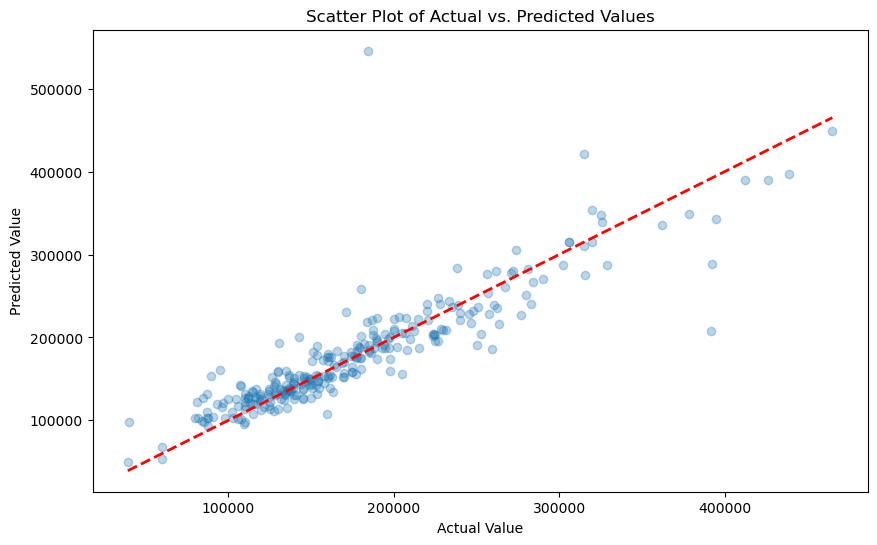

In [93]:
import matplotlib.pyplot as plt

# Assuming 'result' is a DataFrame with the actual targets ('Target') and the predicted values ('Predicted_Value')

# Scatter plot of Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(result['Target'], result['Predicted_Value'], alpha=0.3)
plt.plot([result['Target'].min(), result['Target'].max()], [result['Target'].min(), result['Target'].max()], '--r', linewidth=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.show()


### Scatter Plot of Predicted vs. Actual Values

This plot displays each predicted value against its corresponding actual value.

- **Ideal Scenario**: In a perfect model, all points would lie on the diagonal line, indicating that predictions are exactly the same as the actual values.
- **Good Fit**: Points clustered around the diagonal line suggest a good fit; the closer they are to the line, the better the predictions.
- **Systematic Bias**: Systematic deviations above or below the diagonal line might indicate a bias in the predictions.
- **Variance**: A wide spread of points around the diagonal line suggests high variance and inconsistent prediction accuracy.


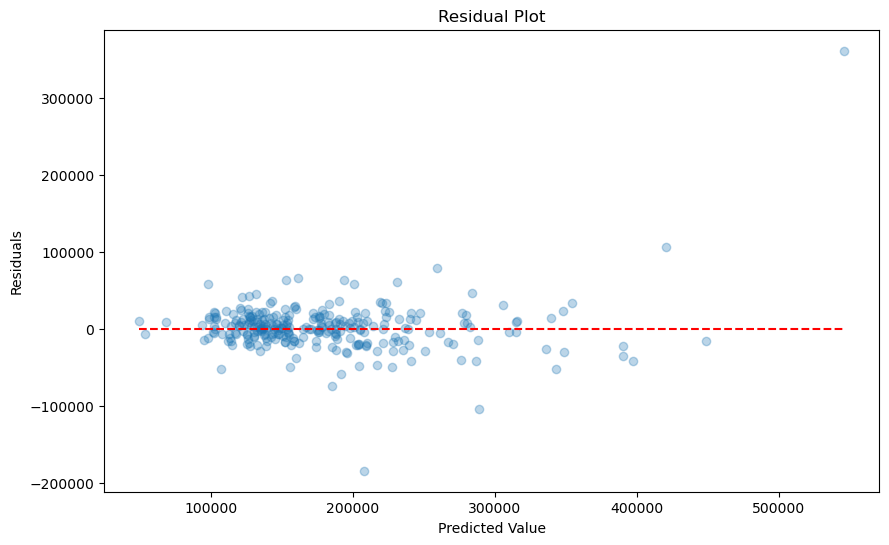

In [94]:
# Residual Plot
residuals = result['Predicted_Value'] - result['Target']
plt.figure(figsize=(10, 6))
plt.scatter(result['Predicted_Value'], residuals, alpha=0.3)
plt.hlines(y=0, xmin=result['Predicted_Value'].min(), xmax=result['Predicted_Value'].max(), colors='r', linestyles='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Residual Plot

The residual plot shows the residuals (the differences between actual and predicted values) against the predicted values.

- **Random Distribution**: Ideally, residuals should be randomly distributed around the horizontal line at zero, with no discernible pattern.
- **Patterns or Trends**: Structured patterns, such as curves or clustered groups, suggest that the model is not capturing some aspect of the data's structure.
- **Homoscedasticity**: The spread of residuals should be roughly constant across all levels of predicted values. A spread that increases or decreases with predicted value indicates heteroscedasticity.


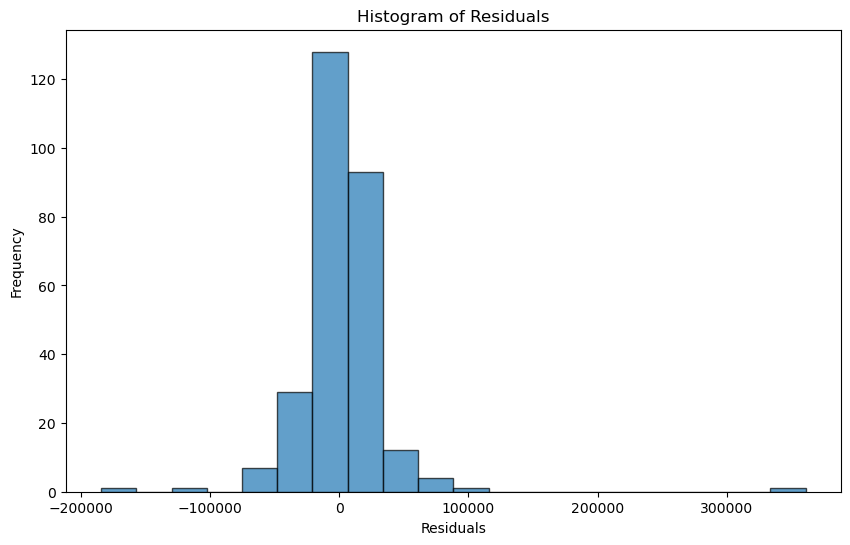

In [95]:
# Histogram of the Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Histogram of the Residuals

The histogram of residuals shows the frequency of each range of residual values.

- **Normal Distribution**: A well-fitting model should have residuals normally distributed around zero, indicated by a bell-shaped curve with the peak at zero.
- **Skewness**: A non-symmetrical histogram suggests systematic over or under-prediction.
- **Outliers**: Bars on the far left or right indicate the presence of outliers where the model's predictions were significantly off.


## SHAP